
**Proposition 1: Offshore Intermediary Networks Exhibit Scale-Free Centrality and Targeted Vulnerability.**

*   **Core Idea:** The network connecting clients to the intermediaries who facilitate offshore structures is characterized by a high degree of centrality, where a few "hub" intermediaries serve a disproportionate number of clients, making the overall network susceptible to targeted disruption aimed at these key players.
*   **Building on:** Network science principles (Barabási & Albert, 1999), empirical findings on offshore networks (Chang et al. 2023 - Complex Systems), supply-side vulnerability arguments (Alstadsæter et al. 2019), and sociological insights on trust concentration (Harrington, 2016).
*   **Contribution:** While Chang et al. (2023) identified scale-free properties in specific contexts (e.g., sanctioned oligarchs), this proposition aims to *systematically quantify* these structural properties across the broader Offshore Leaks Database, explicitly link intermediary centrality to network vulnerability, and test if specific intermediary *types* dominate these central positions.
*   **Sub-propositions:**
    *   **1a. Power-Law Distribution of Intermediary Connectivity:** The distribution of the number of clients served per intermediary will follow a power law, indicating the presence of highly connected "hub" intermediaries. *Contribution:* Confirms and quantifies the scale-free nature specifically for the *intermediary* nodes across the comprehensive ICIJ dataset.
    *   **1b. Hub Intermediary Dominance and Network Fragility:** The overall connectivity and integrity of the client-intermediary network are disproportionately dependent on a small number of high-degree intermediary hubs. Simulated or observed removal of these top intermediaries (ranked by centrality metrics) will lead to significantly greater network fragmentation compared to random node removal. *Contribution:* Explicitly tests the vulnerability implication of the scale-free structure by focusing on intermediary removal, linking network science to Alstadsæter et al.'s (2019) supply-side control argument.
    *   **1c. Functional Specialization of Hub Intermediaries:** Certain *types* of intermediaries (as defined in 2.1.2 - e.g., Legal Experts, Administrators) will be significantly over-represented among the high-centrality network hubs, suggesting that specific functions are critical bottlenecks in the offshore facilitation process. *Contribution:* Adds a functional dimension to the structural analysis of hubs, investigating *which kinds* of intermediaries become central.

**Proposition 2: Intermediary Network Structures and Vulnerabilities Vary Systematically with Client Home Country Governance.**

*   **Core Idea:** The way clients connect to intermediaries, the resulting network structure, and the vulnerability of key intermediaries are not uniform globally but are shaped by the political and institutional environment (rule of law, regime type, corruption) of the clients' home countries.
*   **Building on:** Chang et al. (2023 - Secrecy Strategies), Alstadsæter et al. (2019 - inequality/evasion links), comparative institutionalism, and sociological work on trust in different contexts (Harrington, 2016).
*   **Contribution:** Extends Chang et al.'s work on secrecy *strategies* by systematically examining how client home country governance shapes the *measurable network structure* centered on intermediaries (e.g., intermediary centrality distributions, clustering, specialization) and the *differential vulnerability* of these intermediary networks, using comprehensive governance indicators (WJP, VDEM) across the full dataset.
*   **Sub-propositions:**
    *   **2a. Governance-Dependent Intermediary Network Topologies:** Key intermediary-centric network metrics (e.g., parameters of the intermediary degree distribution, average intermediary clustering coefficient, network density around intermediaries) will differ significantly and predictably based on the governance indicators (WJP Rule of Law, V-Dem Regime Type, TI CPI) of the client cohorts' home countries. *Contribution:* Quantifies the link between macro-level governance and the micro-level structure of intermediary networks.
    *   **2b. Contextual Variation in Intermediary Hub Fragility:** The "super-fragility" observed by Chang et al. (2023) will manifest as heightened network fragmentation upon removal of top *intermediary hubs* specifically for client cohorts from countries with weaker rule of law or more autocratic regimes, potentially reflecting concentrated trust patterns or higher reliance on specific "gatekeepers" in such contexts. *Contribution:* Tests the fragility hypothesis specifically on intermediary hubs and links it systematically to governance indicators.
    *   **2c. Intermediary Specialization Based on Client Governance Profile:** Intermediaries will exhibit measurable specialization, tending to serve clusters of clients predominantly from countries with similar governance profiles (e.g., intermediaries specializing in clients from high-corruption countries vs. those specializing in clients from strong rule-of-law countries). *Contribution:* Moves beyond geographic specialization to test for intermediary specialization based on the *political-institutional* context of their clientele.

**Proposition 3: The Functional Roles and Network Positions of Intermediary Types Vary with Client Governance Context.**

*   **Core Idea:** The *types* of intermediaries (Legal, Tax, Admin, Investment) that are most prominent, central, or interconnected within the network depend on the governance context of their clients, reflecting varying demands for specific forms of expertise (e.g., legal protection vs. sophisticated tax planning vs. basic administration).
*   **Building on:** The intermediary typology (EU 2017; Harrington 2016), qualitative insights on intermediary roles, and the logic linking governance to secrecy needs (Chang et al. 2023).
*   **Contribution:** This proposition quantitatively tests the relationship between client governance context and the *functional composition* of the intermediary network. It moves beyond simply identifying types to analyze their *relative prominence, centrality, and interplay* within the network structure as shaped by client origin.
*   **Sub-propositions:**
    *   **3a. Governance-Driven Prominence of Intermediary Functions:** The relative share of network activity (e.g., number of connections, aggregate centrality) accounted for by different intermediary *types* (Legal, Tax, Admin, Investment) will vary significantly and predictably based on the governance indicators of the client cohorts' home countries. *Contribution:* Quantifies how client context shapes the demand for specific intermediary functions within the network.
    *   **3b. Contextual Determination of Critical Intermediary Hub Types:** The *type* of intermediary most likely to occupy a high-centrality hub position (as identified in Prop 1c) will differ based on client home country governance. For instance, Legal Experts may be more central hubs for clients from weak rule-of-law states, while Tax Experts may be hubs for clients from high-tax/strong-enforcement states. *Contribution:* Integrates network structure (hub status) with intermediary function (type) and client context (governance).
    *   **3c. Varying Intermediary Ecosystems by Client Context:** The patterns of co-occurrence or collaboration *between different types* of intermediaries serving the same client will vary based on the client's home country governance. For example, clients from complex regulatory environments might exhibit denser connections involving multiple specialist intermediary types. *Contribution:* Explores how governance shapes the functional ecosystem and potential division of labor among different intermediary types.

**Proposition 4: Intermediary Network Dynamics are Driven by Supply-Side Factors and Regulatory Shocks.**

*   **Core Idea:** Changes in the offshore landscape, such as the introduction of new legal vehicles by tax havens or major international regulatory initiatives (like CRS), significantly impact the structure and activity within the intermediary network, influencing which intermediaries are active, their centrality, and how they connect to clients.
*   **Building on:** Laffitte (2024) on legal innovations, Alstadsæter et al. (2019) on detection probability/costs, Christensen (2024) and Farrell & Newman (2019) on regulatory shocks/weaponized interdependence, and O'Donovan et al. (2019) on market reactions to transparency shocks.
*   **Contribution:** While prior work studied the *impact* of these factors, this proposition specifically analyzes their effect on the *intermediary network structure*. It aims to quantify how supply-side changes reshape intermediary activity, centrality, specialization, and overall network topology, potentially using event-study or difference-in-differences approaches applied to network metrics over time.
*   **Sub-propositions:**
    *   **4a. Intermediary Response to Legal Innovation:** Following Laffitte (2024), the introduction of significant new legal vehicles in offshore jurisdictions will be associated with measurable changes in the activity levels, client base composition, or network centrality of *intermediaries* specializing in or operating from those jurisdictions. *Contribution:* Links macro-level legal changes (Laffitte) to observable shifts in micro-level intermediary network roles.
    *   **4b. Regulatory Shocks Reshape Intermediary Network Topology:** Major regulatory shocks, particularly the phased implementation of the Common Reporting Standard (CRS), will lead to detectable shifts in the intermediary network structure, such as changes in overall network density, shifts in the centrality ranking of intermediaries, potential exit of certain intermediary types, or altered geographic patterns of intermediary-client links. *Contribution:* Applies event analysis logic (O'Donovan et al.) to track the evolution of the *intermediary network itself* in response to major regulatory interventions (Christensen, Alstadsæter).
    *   **4c. Heterogeneous Intermediary Reactions to Supply Shocks:** The impact of legal innovations (4a) and regulatory shocks (4b) on intermediaries and their network position will vary significantly depending on the *type* of intermediary (e.g., Tax Experts vs. Administrators might react differently to CRS) and the *governance context* of the clients they primarily serve (linking back to Prop 2 & 3). *Contribution:* Examines differential effects, recognizing that intermediaries are not a monolithic group and serve diverse clienteles facing different pressures.



# Notes

Can we also show that it obeys general gravity equation like Lafitte?
And more importantly, then identify clear chokepoints like in Complex Systems of Secrecy of China using Hong Kong as entry point by the fact that we have something that's predicted.

### Complex systems of secrecy:

 sitauted iwhtin sanctions literature. Effectivenes there.

 They use all intermediaires, not distinguishing between any of them.

Show degree distributions of htem + knock-out experiments to show they're vulnerable...

Focus on Hong Kong, Russia, USA and China

And such unwary statements generalising from 2x2 comparison case....: "Together, this suggests divergent macroscale behav-
ior between autocratic and democratic nations."

Sounds like they're lumping all intermediaries under the label of "wealth managers"?

Beneficiary to intermdiary ratio across all countries.


### Secrecy Strategies: Global Patterns in Elites' Quest for Confidentialiy in Offshore Finance.

Merging ICIJ and WJP rule of law

Goal: "At the same time, secrecy is the most
important product of the offshore system and the phenomenon most urgently in need of
analysis (Harrington in press). Better understanding of the ways secrecy is organized
and patterned would contribute not only to better policy but to better theories of
stratification, elites and financial crime"

1. Elites from corrupt countries more likely to spread their assets across multiple offshore financial centers
2. In countries where risk of government confiscation of private assets is high, elites make use of identity-concealing offshore strategies ushc as **bearer instruments** and **nominees** to shield.
3. Especially corrupt countries, 


Blacklist as follows:
"compute inclusion in blacklisted regions, we use the powerset of all current and previously sanctioned jurisdictions from the European Union"

Analyze three key metrics of secrecy:
1. diversification in the use of offshore financial centers (Shannon entropy);
2. use of identity concealment strategies; and
3. use of blacklisted offshore jurisdictions, including diversification in the use of blacklisted jurisdictions

# Imports

In [23]:
from pathlib import Path
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm
import powerlaw
import random

from collections import defaultdict
import scipy.stats as stats

import itertools

# Set plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### ICIJ

In [24]:
icij_data_path = Path("datasets/ICIJ/data")

addresses_path = icij_data_path / "nodes-addresses.csv"
officers_path = icij_data_path / "nodes-officers.csv"
entities_path = icij_data_path / "nodes-entities.csv"
intermediaries_path = icij_data_path / "nodes-intermediaries.csv"
others_path = icij_data_path / "nodes-others.csv"
relationships_path = icij_data_path / "relationships.csv"

officers_df = pd.read_csv(officers_path)
entities_df = pd.read_csv(entities_path)
intermediaries_df = pd.read_csv(intermediaries_path)
others_df = pd.read_csv(others_path)
relationships_df = pd.read_csv(relationships_path)
addresses_df = pd.read_csv(addresses_path)

/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_67484/2965263412.py:11: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  entities_df = pd.read_csv(entities_path)
/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_67484/2965263412.py:14: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  relationships_df = pd.read_csv(relationships_path)


### Reducing address dimension to create intermediary-officer-entity graph instead.

Addresses by themselves are note especially interesting, so we link it to either entities and officers if they share one

I.e. intermediary -> address -> entity (a 2-degree separation) becomes
intermeidary -> entity instead.

In [25]:
relationships_df.rel_type.unique()

array(['registered_address', 'same_as', 'same_address_as',
       'same_company_as', 'intermediary_of', 'similar', 'officer_of',
       'underlying', 'similar_company_as', 'same_name_as',
       'same_intermediary_as', 'probably_same_officer_as', 'connected_to',
       'same_id_as'], dtype=object)

In [26]:
REL_INTERMEDIARY_OF = 'intermediary_of'
REL_REGISTERED_ADDRESS = 'registered_address'
REL_OFFICER_OF = 'officer_of'

print(f"Filtering for '{REL_INTERMEDIARY_OF}' relationships...")

valid_intermediary_ids = set(intermediaries_df['node_id'])
int_ent_links = relationships_df[
    (relationships_df['rel_type'] == REL_INTERMEDIARY_OF) & 
    (relationships_df['node_id_start'].isin(valid_intermediary_ids))
][['node_id_start', 'node_id_end']].copy()
int_ent_links.rename(columns={'node_id_start': 'intermediary_id', 'node_id_end': 'entity_id'}, inplace=True)
print(f"Found {len(int_ent_links)} intermediary-entity links.")

print(f"Filtering for '{REL_REGISTERED_ADDRESS}' relationships (Entity -> Address)...")

entity_ids = set(entities_df['node_id']) 
ent_addr_links = relationships_df[
    (relationships_df['rel_type'] == REL_REGISTERED_ADDRESS) &
    (relationships_df['node_id_start'].isin(entity_ids))
][['node_id_start', 'node_id_end']].copy()
ent_addr_links.rename(columns={'node_id_start': 'entity_id', 'node_id_end': 'address_id'}, inplace=True)
print(f"Found {len(ent_addr_links)} entity-address links.")

print(f"Filtering for '{REL_OFFICER_OF}' relationships...")
off_ent_links = relationships_df[relationships_df['rel_type'] == REL_OFFICER_OF][['node_id_start', 'node_id_end']].copy()
off_ent_links.rename(columns={'node_id_start': 'officer_id', 'node_id_end': 'entity_id'}, inplace=True)
print(f"Found {len(off_ent_links)} officer-entity links.")

print("Merging links to connect Intermediaries -> Entities -> Addresses/Officers...")

intermediary_connections = int_ent_links.copy()

# Add Address information
intermediary_connections = pd.merge(
    intermediary_connections,
    ent_addr_links,
    on='entity_id',
    how='left' # Keep all intermediary-entity links, even if no address found
)

# Add Officer information
intermediary_connections = pd.merge(
    intermediary_connections,
    off_ent_links,
    on='entity_id',
    how='left' # Keep all intermediary-entity links, even if no officer found
)

print(f"Generated {len(intermediary_connections)} potential connection paths.")

print("Adding node details...")

# Add Intermediary details
intermediaries_df_details = intermediaries_df[['node_id', 'name']].add_prefix('intermediary_')
intermediary_connections = pd.merge(
    intermediary_connections,
    intermediaries_df_details,
    left_on='intermediary_id',      # Column name in intermediary_connections
    right_on='intermediary_node_id', # Column name in intermediaries_df_details
    
    how='left'
)

# Add Entity details
entities_df_details = entities_df[['node_id', 'name']].add_prefix('entity_')
intermediary_connections = pd.merge(
    intermediary_connections,
    entities_df_details,
    left_on='entity_id',
    right_on='entity_node_id',
    how='left'
)

# Add Address details (handle potential NaN address_ids from left join)
addresses_df_details = addresses_df[['node_id', 'address', 'country_codes']].add_prefix('address_')
intermediary_connections = pd.merge(
    intermediary_connections,
    addresses_df_details,
    left_on='address_id',
    right_on='address_node_id',
    how='left'
)

# Add Officer details (handle potential NaN officer_ids from left join)
officers_df_details = officers_df[['node_id', 'name']].add_prefix('officer_')
intermediary_connections = pd.merge(
    intermediary_connections,
    officers_df_details,
    left_on='officer_id',
    right_on='officer_node_id',
    how='left'
)

print("Finished creating intermediary connection details DataFrame.")
print(intermediary_connections.head())

# Create new 1st degree relationships using vectorized operations
entity_relationships = pd.DataFrame({
    'node_id_start': intermediary_connections['entity_node_id'],
    'node_id_end': intermediary_connections['intermediary_id'],
    'rel_type': 'entity_has_intermediary'
})

officer_relationships = pd.DataFrame({
    'node_id_start': intermediary_connections['officer_node_id'],
    'node_id_end': intermediary_connections['intermediary_id'],
    'rel_type': 'officer_has_intermediary'
})

new_relationships = pd.concat([entity_relationships, officer_relationships], ignore_index=True)

# Create a new DataFrame for the 1st degree relationships
new_relationships_df = pd.DataFrame(new_relationships)

print("\nNew 1st degree relationships DataFrame:")
print(new_relationships_df.head())

# concatting back onto the original relationships_df
relationships_df = pd.concat([relationships_df, new_relationships_df], ignore_index=True)

print("\nUpdated relationships_df with new 1st degree relationships:")
print(relationships_df.head())

Filtering for 'intermediary_of' relationships...
Found 598546 intermediary-entity links.
Filtering for 'registered_address' relationships (Entity -> Address)...
Found 337573 entity-address links.
Filtering for 'officer_of' relationships...
Found 1720357 officer-entity links.
Merging links to connect Intermediaries -> Entities -> Addresses/Officers...
Generated 1153023 potential connection paths.
Adding node details...
Finished creating intermediary connection details DataFrame.
   intermediary_id  entity_id  address_id  officer_id  intermediary_node_id  \
0         11000001   10208879         NaN  12216404.0              11000001   
1         11000001   10208879         NaN  12216405.0              11000001   
2         11000001   10208879         NaN  12216499.0              11000001   
3         11000001   10208879         NaN  12216500.0              11000001   
4         11000001   10198662         NaN  12002946.0              11000001   

         intermediary_name  entity_node_id

In [27]:
intermediary_connections.head()

,intermediary_id,entity_id,address_id,officer_id,intermediary_node_id,intermediary_name,entity_node_id,entity_name,address_node_id,address_address,address_country_codes,officer_node_id,officer_name
0,11000001,10208879,NaN,12216404.0,11000001,"MICHAEL PAPAGEORGE, MR.",10208879,FOURPASS DEVELOP CORP.,NaN,NaN,NaN,12216404.0,HANNAH LEAH NORTON
1,11000001,10208879,NaN,12216405.0,11000001,"MICHAEL PAPAGEORGE, MR.",10208879,FOURPASS DEVELOP CORP.,NaN,NaN,NaN,12216405.0,REBECCA SARAH NORTON
2,11000001,10208879,NaN,12216499.0,11000001,"MICHAEL PAPAGEORGE, MR.",10208879,FOURPASS DEVELOP CORP.,NaN,NaN,NaN,12216499.0,JEFFREY GRANT NORTON
3,11000001,10208879,NaN,12216500.0,11000001,"MICHAEL PAPAGEORGE, MR.",10208879,FOURPASS DEVELOP CORP.,NaN,NaN,NaN,12216500.0,ANNE CHRISTINE NORTON
4,11000001,10198662,NaN,12002946.0,11000001,"MICHAEL PAPAGEORGE, MR.",10198662,MIKELLI INVESTMENTS LIMITED,NaN,NaN,NaN,12002946.0,THE BEARER


### Enriching intermediaries_df with different degrees

In [ ]:
intermediary_degrees = relationships_df[
    (relationships_df['node_id_start'].isin(intermediaries_df['node_id'])) |
    (relationships_df['node_id_end'].isin(intermediaries_df['node_id']))
].copy()

officer_relationships = intermediary_degrees[intermediary_degrees['rel_type'] == 'officer_has_intermediary']
entity_relationships = intermediary_degrees[intermediary_degrees['rel_type'] == 'entity_has_intermediary']

officer_degrees = officer_relationships.groupby('intermediary_node').size().reset_index(name='officer_degree')
entity_degrees = entity_relationships.groupby('intermediary_node').size().reset_index(name='entity_degree')

officer_countries = officer_relationships.merge(
    officers_df[['node_id', 'country_codes']], 
    left_on='node_id_end',
    right_on='node_id',
    how='left'
).drop_duplicates(subset=['intermediary_node', 'country_codes']).groupby('intermediary_node')['country_codes'].count().reset_index(name='officer_n_countries')

entity_countries = entity_relationships.merge(
    entities_df[['node_id', 'country_codes']], 
    left_on='node_id_end',
    right_on='node_id',
    how='left'
).drop_duplicates(subset=['intermediary_node', 'country_codes']).groupby('intermediary_node')['country_codes'].count().reset_index(name='entities_n_countries')

# Merge all metrics back with intermediaries_df using distinct suffixes
intermediaries_df = intermediaries_df.merge(
    officer_degrees,
    left_on='node_id',
    right_on='intermediary_node',
    how='left',
    suffixes=('', '_officer')
).merge(
    entity_degrees,
    left_on='node_id',
    right_on='intermediary_node',
    how='left',
    suffixes=('', '_entity')
).merge(
    officer_countries,
    left_on='node_id',
    right_on='intermediary_node',
    how='left',
    suffixes=('', '_officer_countries')
).merge(
    entity_countries,
    left_on='node_id',
    right_on='intermediary_node',
    how='left',
    suffixes=('', '_entity_countries')
)

# Fill NaN values with 0
intermediaries_df = intermediaries_df.fillna({
    'officer_degree': 0,
    'entity_degree': 0,
    'officer_n_countries': 0,
    'entities_n_countries': 0
})

intermediaries_df[['name', 'officer_degree', 'entity_degree', 'officer_n_countries', 'entities_n_countries']].head()

,name,officer_degree,entity_degree,officer_n_countries,entities_n_countries
0,"MICHAEL PAPAGEORGE, MR.",13.0,13.0,0.0,0.0
1,CORFIDUCIA ANSTALT,13.0,13.0,0.0,0.0
2,"DAVID, RONALD",1.0,1.0,0.0,0.0
3,"DE BOUTSELIS, JEAN-PIERRE",0.0,0.0,0.0,0.0
4,THE LEVANT LAWYERS (TLL),47.0,47.0,0.0,0.0


### Visualising intermediaries


Network Statistics:
Total Nodes: 18
Total Edges: 17
Connected Officers: 12
Connected Entities: 5
Connected Intermediaries: 1


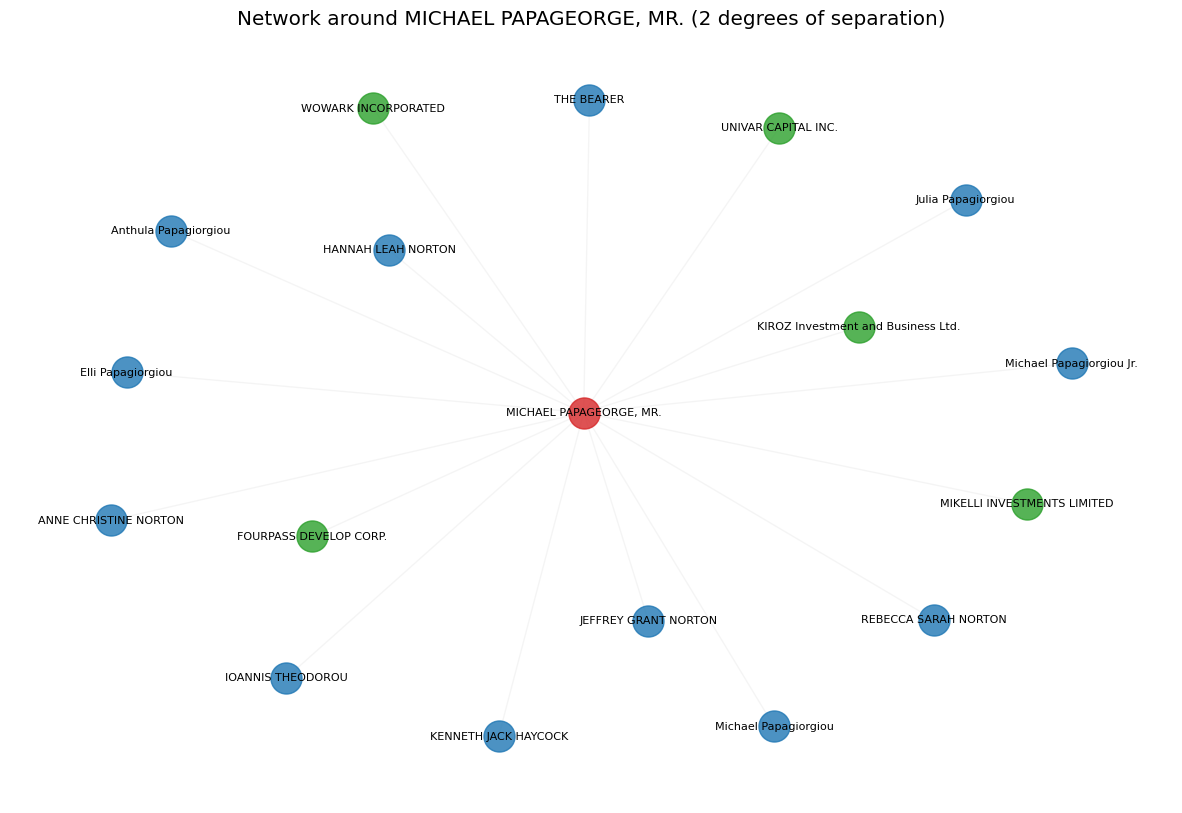

In [21]:
def visualize_intermediary_network(intermediary_name, officers_df, entities_df, intermediaries_df, relationships_df, ax=None):
    intermediary = intermediaries_df[intermediaries_df['name'] == intermediary_name]
    if intermediary.empty:
        print(f"Intermediary '{intermediary_name}' not found.")
        return
    
    intermediary_id = intermediary.iloc[0]['node_id']
    
    G = nx.Graph()
    
    G.add_node(intermediary_id, node_type='intermediary', **intermediary.iloc[0].to_dict())
    
    mask = (relationships_df['node_id_start'] == intermediary_id) | (relationships_df['node_id_end'] == intermediary_id)
    intermediary_relationships = relationships_df[mask]
    
    second_degree_nodes = set()
    
    for _, rel in intermediary_relationships.iterrows():
        other_node = rel['node_id_end'] if rel['node_id_start'] == intermediary_id else rel['node_id_start']
        second_degree_nodes.add(other_node)
        
        officer = officers_df[officers_df['node_id'] == other_node]
        if not officer.empty:
            G.add_node(other_node, node_type='officer', **officer.iloc[0].to_dict())
            G.add_edge(intermediary_id, other_node, **rel.to_dict())
            continue
            
        entity = entities_df[entities_df['node_id'] == other_node]
        if not entity.empty:
            G.add_node(other_node, node_type='entity', **entity.iloc[0].to_dict())
            G.add_edge(intermediary_id, other_node, **rel.to_dict())
            continue
            
        other_intermediary = intermediaries_df[intermediaries_df['node_id'] == other_node]
        if not other_intermediary.empty:
            G.add_node(other_node, node_type='intermediary', **other_intermediary.iloc[0].to_dict())
            G.add_edge(intermediary_id, other_node, **rel.to_dict())
    
    for node in second_degree_nodes:
        mask = (relationships_df['node_id_start'] == node) | (relationships_df['node_id_end'] == node)
        second_degree_relationships = relationships_df[mask]
        
        for _, rel in second_degree_relationships.iterrows():
            connected_node = rel['node_id_end'] if rel['node_id_start'] == node else rel['node_id_start']
            
            if connected_node in G.nodes():
                continue
                
            officer = officers_df[officers_df['node_id'] == connected_node]
            if not officer.empty:
                G.add_node(connected_node, node_type='officer', **officer.iloc[0].to_dict())
                G.add_edge(node, connected_node, **rel.to_dict())
                continue
                
            entity = entities_df[entities_df['node_id'] == connected_node]
            if not entity.empty:
                G.add_node(connected_node, node_type='entity', **entity.iloc[0].to_dict())
                G.add_edge(node, connected_node, **rel.to_dict())
                continue
                
            other_intermediary = intermediaries_df[intermediaries_df['node_id'] == connected_node]
            if not other_intermediary.empty:
                G.add_node(connected_node, node_type='intermediary', **other_intermediary.iloc[0].to_dict())
                G.add_edge(node, connected_node, **rel.to_dict())
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    
    node_colors = {
        'officer': '#1f77b4',      # Blue
        'entity': '#2ca02c',       # Green
        'intermediary': '#d62728'   # Red
    }
    
    pos = nx.spring_layout(G, k=2, iterations=100)
    
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='#cccccc', ax=ax)
    
    for node_type, color in node_colors.items():
        node_list = [n for n, d in G.nodes(data=True) if d['node_type'] == node_type]
        if node_list:
            nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=color, 
                                 node_size=500, alpha=0.8, ax=ax)
    
    labels = {n: d.get('name', n) for n, d in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    
    ax.set_title(f'Network around {intermediary_name} (2 degrees of separation)')
    ax.axis('off')
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    print(f"\nNetwork Statistics:")
    print(f"Total Nodes: {G.number_of_nodes()}")
    print(f"Total Edges: {G.number_of_edges()}")
    print(f"Connected Officers: {len([n for n, d in G.nodes(data=True) if d['node_type'] == 'officer'])}")
    print(f"Connected Entities: {len([n for n, d in G.nodes(data=True) if d['node_type'] == 'entity'])}")
    print(f"Connected Intermediaries: {len([n for n, d in G.nodes(data=True) if d['node_type'] == 'intermediary'])}")

random_intermediary = "MICHAEL PAPAGEORGE, MR."
visualize_intermediary_network(random_intermediary, officers_df, entities_df, intermediaries_df, relationships_df)


KeyboardInterrupt: 

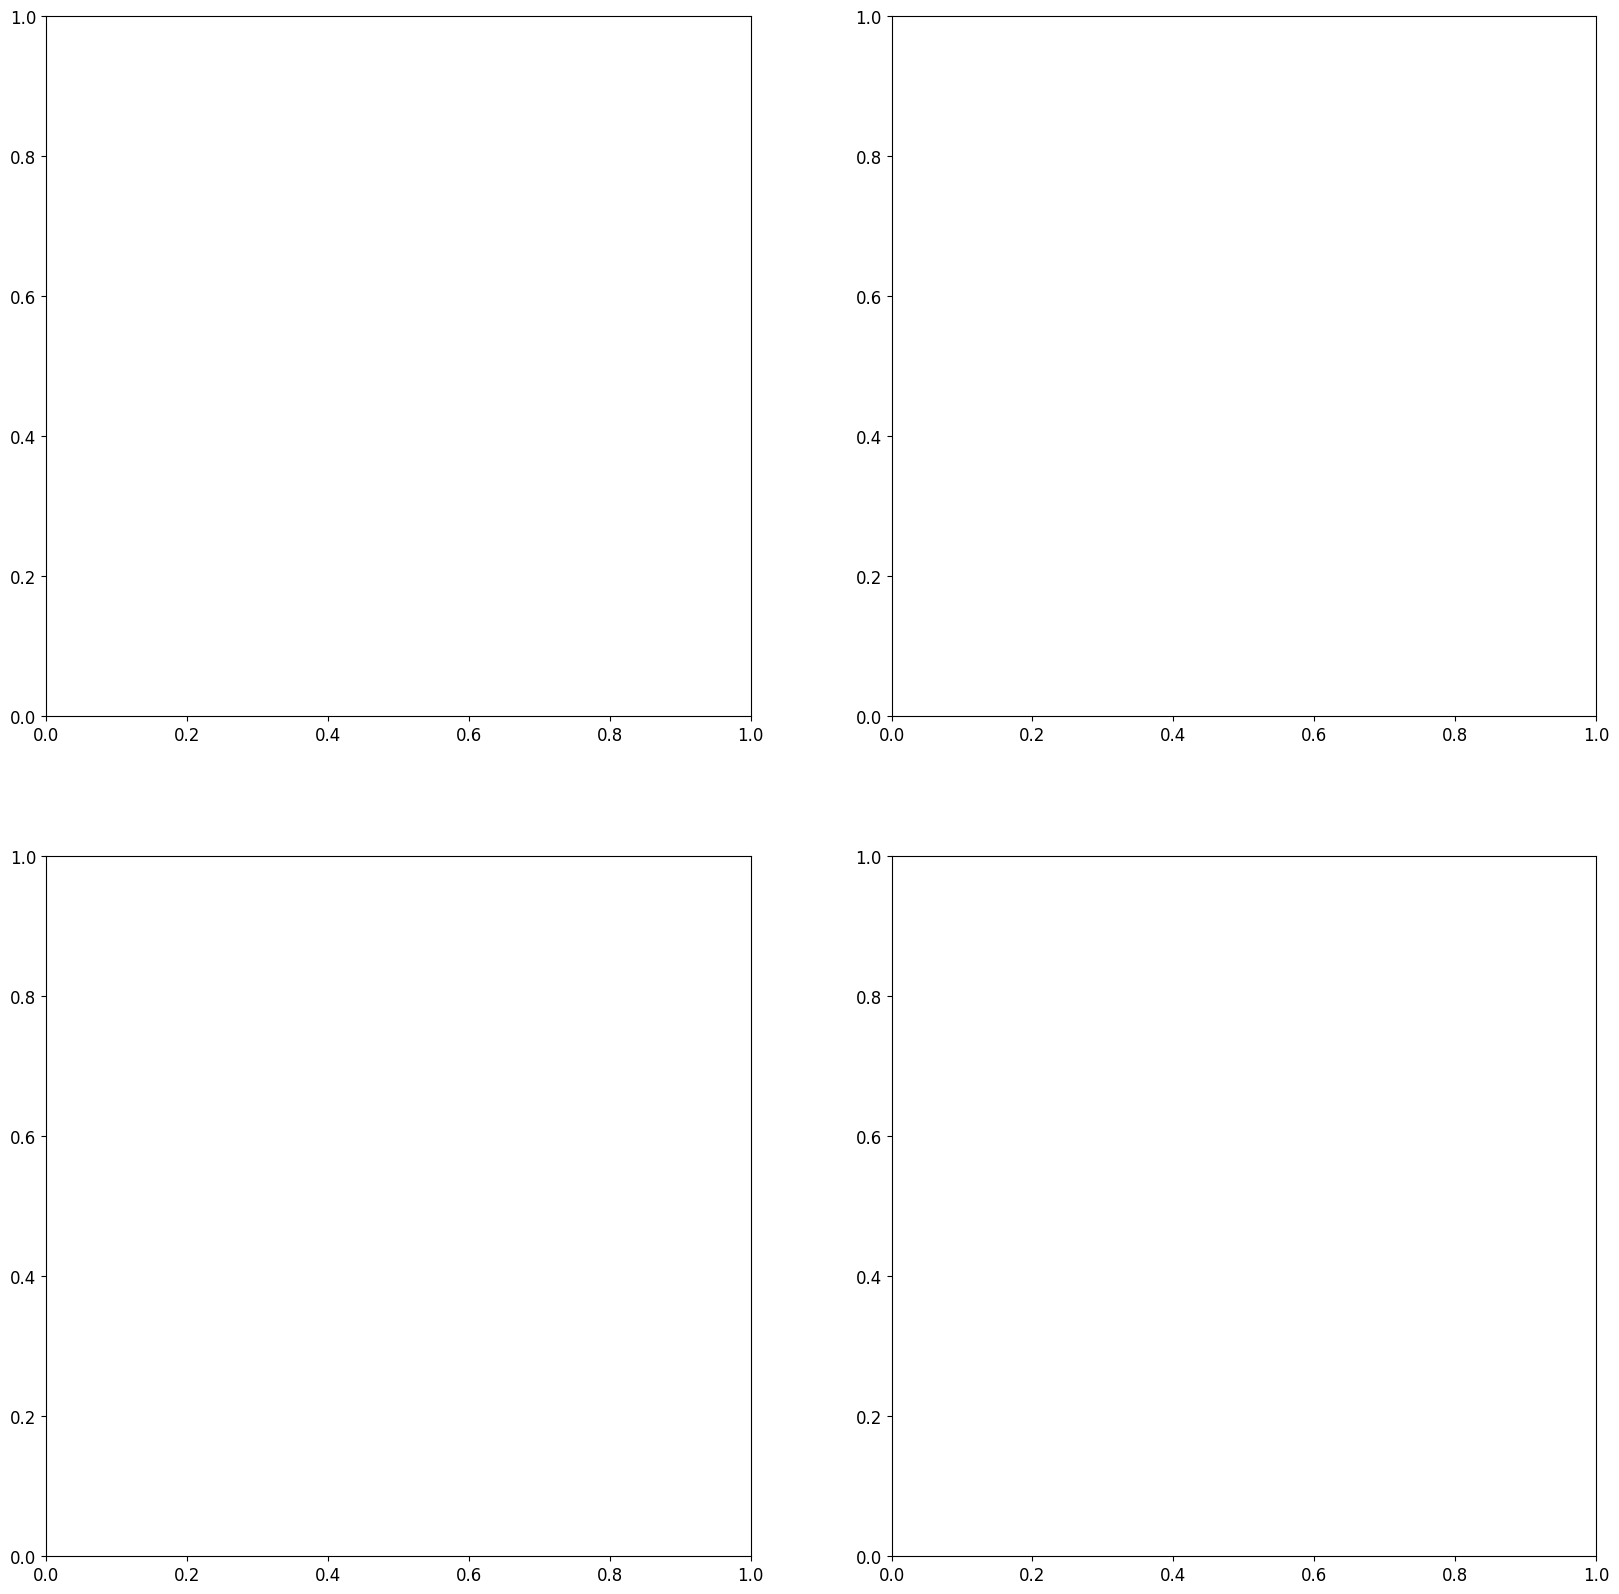

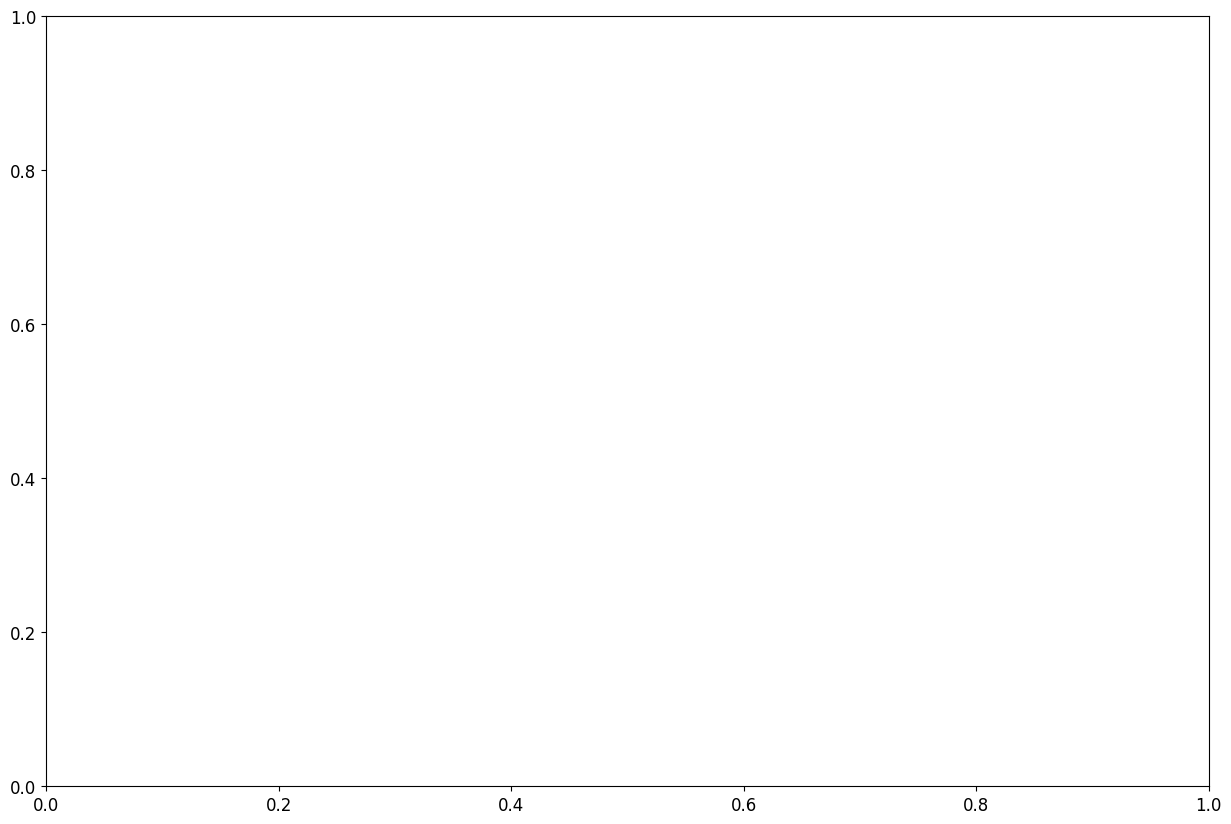

In [22]:
# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()

# Get 4 random intermediaries
random_intermediaries = intermediaries_df.sample(n=4)['name'].tolist()

# Plot each intermediary's network in a subplot
for idx, intermediary_name in enumerate(random_intermediaries):
    plt.sca(axes[idx])
    visualize_intermediary_network(intermediary_name, officers_df, entities_df, intermediaries_df, relationships_df)
    axes[idx].set_title(f'Network {idx+1}: {intermediary_name}')

plt.tight_layout()
plt.show()


# Data Wrangling

Adding relationship between intermediary and officer / entity / intermediary if they share an address.
node_id_start and node_id_end those respecitvely. Rel_type = "share_address". Nothing in the other fields


### Enrichment data of intermediary type
Have their own datasets + joined back onto intermediaries_df

In [21]:
enriched_random_sample_500_path = Path("enrichment_data/enriched_random_sample_500.csv")
enriched_top_5_percent_intermediaries_path = Path("enrichment_data/enriched_top_5_percent_intermediaries.csv")

entities_df_enriched_random_sample_500 = pd.read_csv(enriched_random_sample_500_path)
entities_df_enriched_top_5_percent_intermediaries = pd.read_csv(enriched_top_5_percent_intermediaries_path)

# only keeping entries where we're confident about hte enrichment
entities_df_enriched_random_sample_500 = entities_df_enriched_random_sample_500[
    (entities_df_enriched_random_sample_500["confidence"] == "High") & 
    (entities_df_enriched_random_sample_500["classification"] != "ERROR")
]
entities_df_enriched_top_5_percent_intermediaries = entities_df_enriched_top_5_percent_intermediaries[
    (entities_df_enriched_top_5_percent_intermediaries["confidence"] == "High") & 
    (entities_df_enriched_top_5_percent_intermediaries["classification"] != "ERROR")
]

In [22]:
# Deduplicate intermediaries_df on name first
intermediaries_df = intermediaries_df.drop_duplicates(subset=['name'])

intermediary_connections = relationships_df[relationships_df['rel_type'] == 'intermediary_of']
officers_per_intermediary = intermediary_connections.groupby('node_id_start').size()
intermediaries_df['degree'] = intermediaries_df['node_id'].map(officers_per_intermediary)
intermediaries_df['log_degree'] = np.log10(intermediaries_df['degree'])

# Left join the enriched data onto intermediaries
merged_entities_df_enriched_top_5_percent_intermediaries = entities_df_enriched_top_5_percent_intermediaries.merge(
    intermediaries_df,
    left_on='name',
    right_on='name',
    how='inner'
)
merged_entities_df_enriched_random_sample_500 = entities_df_enriched_random_sample_500.merge(
    intermediaries_df,
    left_on='name',
    right_on='name',
    how='inner'
)

In [23]:
intermediares_df_enriched = intermediaries_df.merge(
    entities_df_enriched_random_sample_500,
    left_on='name',
    right_on='name',
    how='left'
)
intermediares_df_enriched = intermediares_df_enriched.merge(
    entities_df_enriched_top_5_percent_intermediaries,
    left_on='name',
    right_on='name',
    how='left'
)

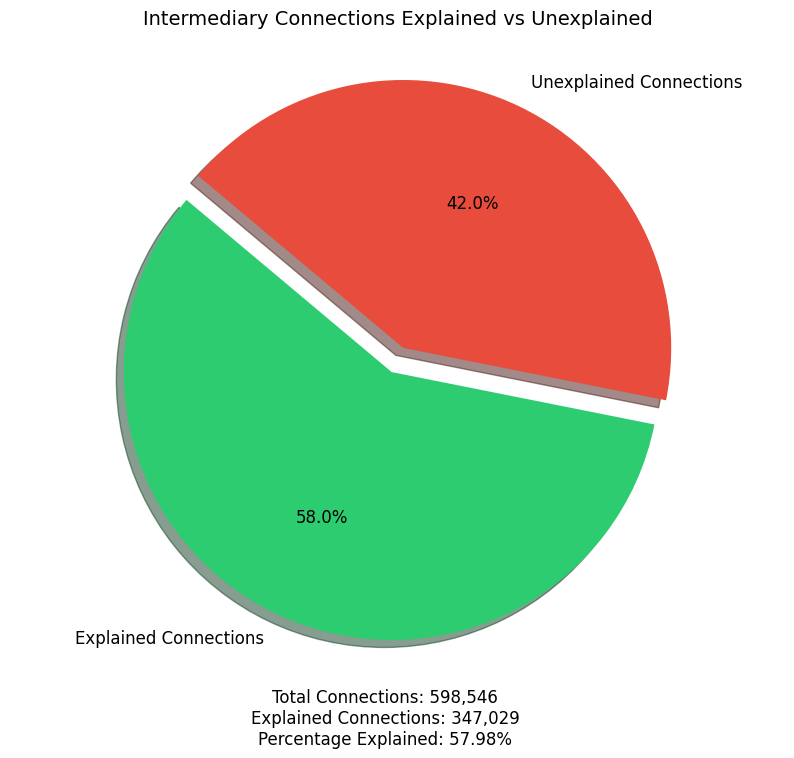

In [24]:
total_intermediary_connections = len(relationships_df[relationships_df['rel_type'] == 'intermediary_of'])

enriched_intermediaries = set(entities_df_enriched_top_5_percent_intermediaries['name'])
explained_connections = relationships_df[
    (relationships_df['rel_type'] == 'intermediary_of') & 
    (relationships_df['node_id_start'].isin(intermediaries_df[intermediaries_df['name'].isin(enriched_intermediaries)]['node_id']))
]
num_explained_connections = len(explained_connections)

percentage_explained = (num_explained_connections / total_intermediary_connections) * 100

plt.figure(figsize=(10, 8))
sizes = [num_explained_connections, total_intermediary_connections - num_explained_connections]
labels = ['Explained Connections', 'Unexplained Connections']
colors = ['#2ecc71', '#e74c3c']
explode = (0.1, 0)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Intermediary Connections Explained vs Unexplained', pad=20, size=14)

plt.figtext(0.5, 0.01, 
            f"Total Connections: {total_intermediary_connections:,}\n"
            f"Explained Connections: {num_explained_connections:,}\n"
            f"Percentage Explained: {percentage_explained:.2f}%",
            ha='center', va='bottom', size=12)

plt.axis('equal')  
plt.show()


In [25]:
intermediares_df_enriched.sort_values(by="degree", ascending=False).head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,...,search_iterations_x,classification_y,confidence_y,role_muddled_y,role_muddled_reasoning_y,justification_y,is_individual_y,job_title_y,search_log_y,search_iterations_y
24624,230000018,Morning Star Holdings Limited,NaN,NaN,NaN,Saint Kitts and Nevis,KNA,Paradise Papers - Nevis corporate registry,Nevis corporate registry data is current throu...,NaN,...,NaN,Administrator,High,False,The role is clearly defined as a registered ag...,Morning Star Holdings Limited is the largest a...,False,Registered Agent,"[{'iteration': 0, 'query': 'Morning Star Holdi...",2.0
23526,23000136,MOSSACK FONSECA & CO. (BAHAMAS) LIMITED,NaN,316,NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN,...,NaN,Legal Expert,High,False,NaN,MOSSACK FONSECA & CO. (BAHAMAS) LIMITED is cla...,False,Law Firm,"[{'iteration': 0, 'query': 'MOSSACK FONSECA & ...",2.0
23536,23000147,UBS TRUSTEES (BAHAMAS) LTD.,NaN,359,NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN,...,NaN,Administrator,High,False,The role is clearly defined as a trustee company.,UBS Trustees (Bahamas) Ltd. is a trust company...,False,Trustee,"[{'iteration': 0, 'query': 'UBS TRUSTEES (BAHA...",2.0
23545,23000156,TRIDENT CORPORATE SERVICES (BAH) LTD,NaN,390,NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN,...,NaN,Administrator,High,False,NaN,Trident Corporate Services (Bahamas) Ltd. is i...,False,Unknown,"[{'iteration': 0, 'query': 'TRIDENT CORPORATE ...",2.0
23523,23000133,MMG BAHAMAS LTD.,NaN,313,NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN,...,NaN,Administrator,High,False,NaN,MMG Bahamas Ltd. appears to be a fund administ...,False,Unknown,"[{'iteration': 0, 'query': 'MMG BAHAMAS LTD.',...",2.0


In [26]:
addresses_df.head()

,node_id,address,name,countries,country_codes,sourceID,valid_until,note
0,24000001,"ANNEX FREDERICK & SHIRLEY STS, P.O. BOX N-4805...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
1,24000002,"SUITE E-2,UNION COURT BUILDING, P.O. BOX N-818...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
2,24000003,"LYFORD CAY HOUSE, LYFORD CAY, P.O. BOX N-7785,...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
3,24000004,"P.O. BOX N-3708 BAHAMAS FINANCIAL CENTRE, P.O....",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
4,24000005,"LYFORD CAY HOUSE, 3RD FLOOR, LYFORD CAY, P.O. ...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN


In [27]:
# Search for node_id 225000017 across all dataframes
node_id = 225000017
# Check officers
officer_match = officers_df[officers_df['node_id'] == node_id]
if not officer_match.empty:
    print(f"Found in officers_df: {officer_match.to_dict('records')}")

# Check addresses
address_match = addresses_df[addresses_df['node_id'] == node_id]
if not address_match.empty:
    print(f"Found in addresses_df: {address_match.to_dict('records')}")
# Check entities
entity_match = entities_df[entities_df['node_id'] == node_id]
if not entity_match.empty:
    print(f"Found in entities_df: {entity_match.to_dict('records')}")

# Check intermediaries
intermediary_match = intermediaries_df[intermediaries_df['node_id'] == node_id]
if not intermediary_match.empty:
    print(f"Found in intermediaries_df: {intermediary_match.to_dict('records')}")

# Check others
other_match = others_df[others_df['node_id'] == node_id]
if not other_match.empty:
    print(f"Found in others_df: {other_match.to_dict('records')}")

# Check relationships (both as start and end node)
start_relationships = relationships_df[relationships_df['node_id_start'] == node_id]
if not start_relationships.empty:
    print(f"Found as start node in relationships_df: {start_relationships.to_dict('records')}")

end_relationships = relationships_df[relationships_df['node_id_end'] == node_id]
if not end_relationships.empty:
    print(f"Found as end node in relationships_df: {end_relationships.to_dict('records')}")

Found in addresses_df: [{'node_id': 225000017, 'address': 'Hunkins Waterfront Plaza, Suite 556, Main Street, Charlestown Nevis', 'name': 'Hunkins Waterfront Plaza, Suite 556, Main Street, Charlestown Nevis', 'countries': 'Saint Kitts and Nevis', 'country_codes': 'KNA', 'sourceID': 'Paradise Papers - Nevis corporate registry', 'valid_until': 'Nevis corporate registry data is current through 2016', 'note': nan}]
Found as end node in relationships_df: [{'node_id_start': 230000018, 'node_id_end': 225000017, 'rel_type': 'registered_address', 'link': 'registered address', 'status': nan, 'start_date': nan, 'end_date': nan, 'sourceID': nan}]


In [28]:
# Get all relationships where node_id 230000018 is either the start or end node
node_connections = relationships_df[
    (relationships_df['node_id_start'] == 230000018) | 
    (relationships_df['node_id_end'] == 230000018)
]
node_connections



,node_id_start,node_id_end,rel_type,link,status,start_date,end_date,sourceID
2360809,230000018,225000017,registered_address,registered address,NaN,NaN,NaN,NaN
2360810,230000018,200110095,intermediary_of,registered agent of,NaN,NaN,NaN,NaN
2360811,230000018,200506393,intermediary_of,registered agent of,NaN,NaN,NaN,NaN
2360812,230000018,200501710,intermediary_of,registered agent of,NaN,NaN,NaN,NaN
2360813,230000018,200139707,intermediary_of,registered agent of,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2396163,230000018,200500757,intermediary_of,registered agent of,NaN,NaN,NaN,NaN
2396164,230000018,200512118,intermediary_of,registered agent of,NaN,NaN,NaN,NaN
2396165,230000018,200137821,intermediary_of,registered agent of,NaN,NaN,NaN,NaN
2396166,230000018,200505171,intermediary_of,registered agent of,NaN,NaN,NaN,NaN


### Country-level data-set
A country-level one where we have some summary statistics of the intermediaries to run regressions on

# Analysis

### Overview of Intermediaries by Country

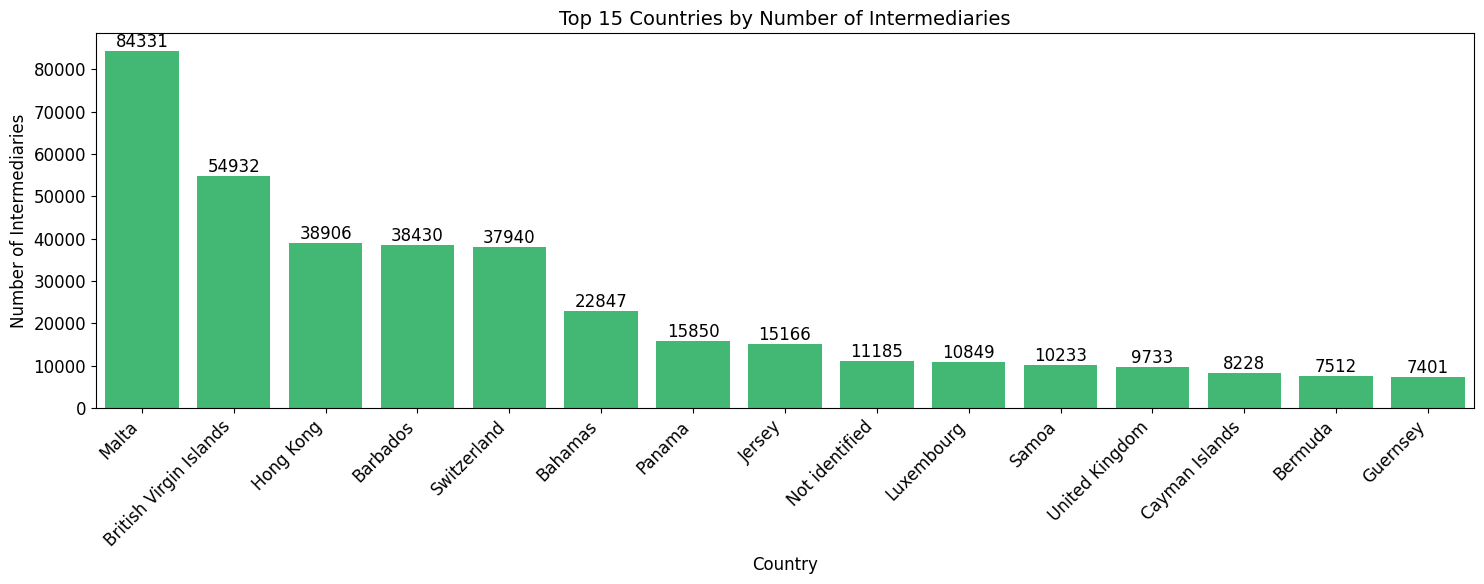

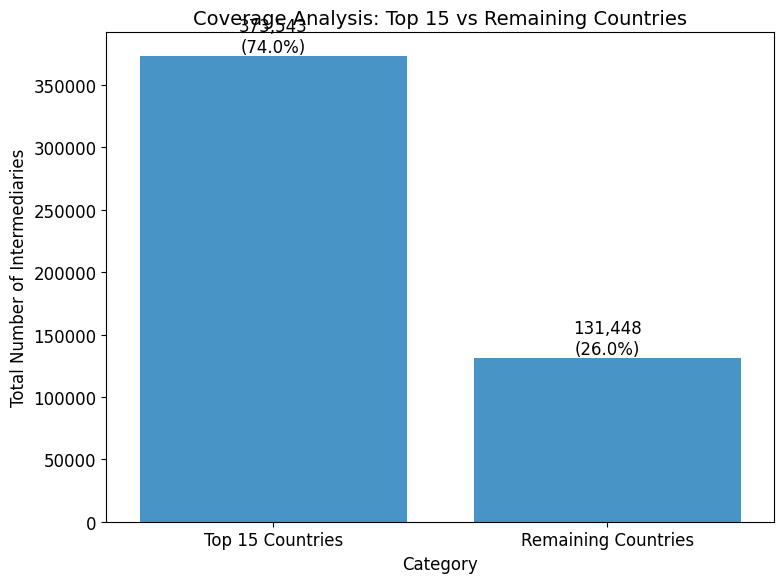

In [33]:
# Create bar plots showing intermediary distribution by country
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Count intermediaries by country
country_counts = entities_df['countries'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Get top 15 countries
top_15_countries = country_counts.head(15)

# Create first bar plot - Top 15 countries
plt.figure(figsize=(15, 6))
sns.barplot(data=top_15_countries, x='country', y='count', color='#2ecc71')

# Customize the first plot
plt.title('Top 15 Countries by Number of Intermediaries', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Number of Intermediaries')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(top_15_countries['count']):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Create second bar plot - Coverage analysis
coverage_data = pd.DataFrame({
    'Category': ['Top 15 Countries', 'Remaining Countries'],
    'Count': [
        top_15_countries['count'].sum(),
        country_counts.iloc[15:]['count'].sum()
    ]
})

plt.figure(figsize=(8, 6))
sns.barplot(data=coverage_data, x='Category', y='Count', color='#3498db')

# Customize the second plot
plt.title('Coverage Analysis: Top 15 vs Remaining Countries', fontsize=14)
plt.ylabel('Total Number of Intermediaries')

# Add value labels and percentage on top of each bar
total = coverage_data['Count'].sum()
for i, v in enumerate(coverage_data['Count']):
    percentage = (v / total) * 100
    plt.text(i, v, f'{v:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Overview of Enrichment Data

In [4]:
entities_df_enriched_random_sample_500['classification'].value_counts()

classification
Administrator         197
Legal Expert          126
Investment Advisor     89
Tax Expert             22
Name: count, dtype: int64

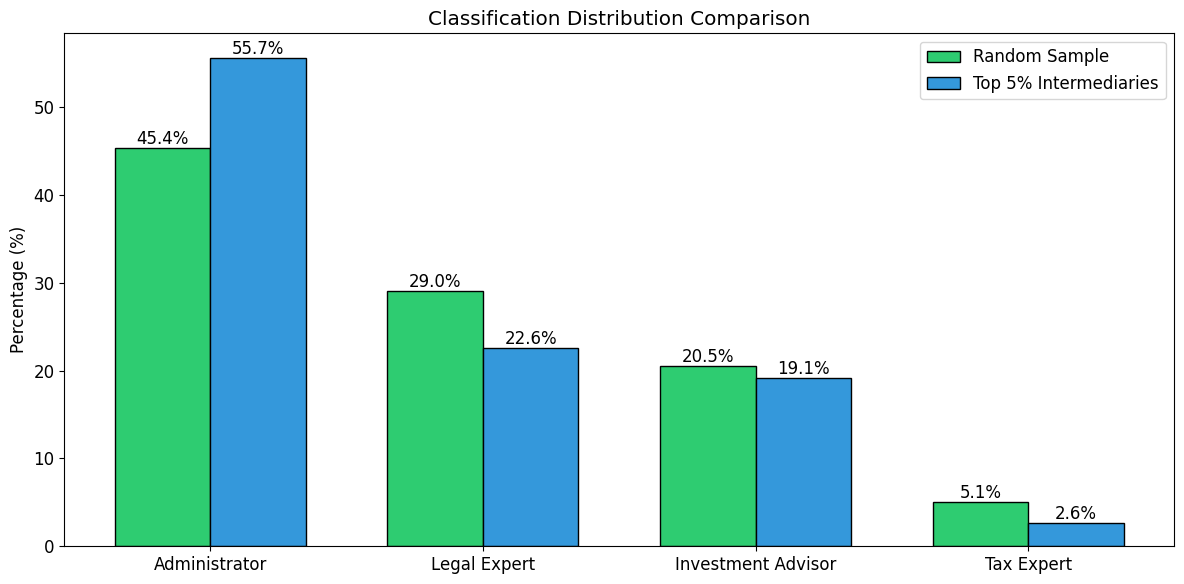

In [5]:
# Create figure
plt.figure(figsize=(12, 6))

# Get the data for both samples
random_sample_data = entities_df_enriched_random_sample_500['classification'].value_counts(normalize=True).mul(100)
top_5_percent_data = entities_df_enriched_top_5_percent_intermediaries['classification'].value_counts(normalize=True).mul(100)

# Create x positions for the bars
x = np.arange(len(random_sample_data))
width = 0.35

# Plot bars for both samples with black edges
for i, classification in enumerate(random_sample_data.index):
    # Random sample bars
    plt.bar(x[i] - width/2, random_sample_data[classification], width, 
            label='Random Sample' if i == 0 else "", 
            color='#2ecc71', edgecolor='black')
    # Top 5% bars
    plt.bar(x[i] + width/2, top_5_percent_data[classification], width, 
            label='Top 5% Intermediaries' if i == 0 else "", 
            color='#3498db', edgecolor='black')
    
    # Add value annotations
    plt.text(x[i] - width/2, random_sample_data[classification], 
             f'{random_sample_data[classification]:.1f}%', 
             ha='center', va='bottom')
    plt.text(x[i] + width/2, top_5_percent_data[classification], 
             f'{top_5_percent_data[classification]:.1f}%', 
             ha='center', va='bottom')

# Customize the plot
plt.title('Classification Distribution Comparison')
plt.ylabel('Percentage (%)')
plt.xticks(x, random_sample_data.index, rotation=0)
plt.legend()

plt.tight_layout()
plt.show()


### Number of officers per intermediary-type

In [28]:
merged_entities_df_enriched_top_5_percent_intermediaries["degree"].describe()

count      345.000000
mean      1039.011594
std       2340.228850
min          1.000000
25%        310.000000
50%        452.000000
75%        918.000000
max      35358.000000
Name: degree, dtype: float64

In [29]:
entities_df_enriched_random_sample_500["classification"].value_counts()

classification
Administrator         197
Legal Expert          126
Investment Advisor     89
Tax Expert             22
Name: count, dtype: int64

In [48]:
merged_entities_df_enriched_random_sample_500["classification"].value_counts()

classification
Administrator         197
Legal Expert          126
Investment Advisor     89
Tax Expert             22
Name: count, dtype: int64


Degree Statistics by Classification:

Legal Expert:
Count: 125
Mean: 11.67
Median: 2.00
Std Dev: 62.83
Min: 1
Max: 665

Investment Advisor:
Count: 89
Mean: 34.10
Median: 2.00
Std Dev: 131.22
Min: 1
Max: 956

Administrator:
Count: 196
Mean: 56.89
Median: 2.00
Std Dev: 330.97
Min: 1
Max: 3601

Tax Expert:
Count: 22
Mean: 25.68
Median: 4.50
Std Dev: 46.00
Min: 1
Max: 194


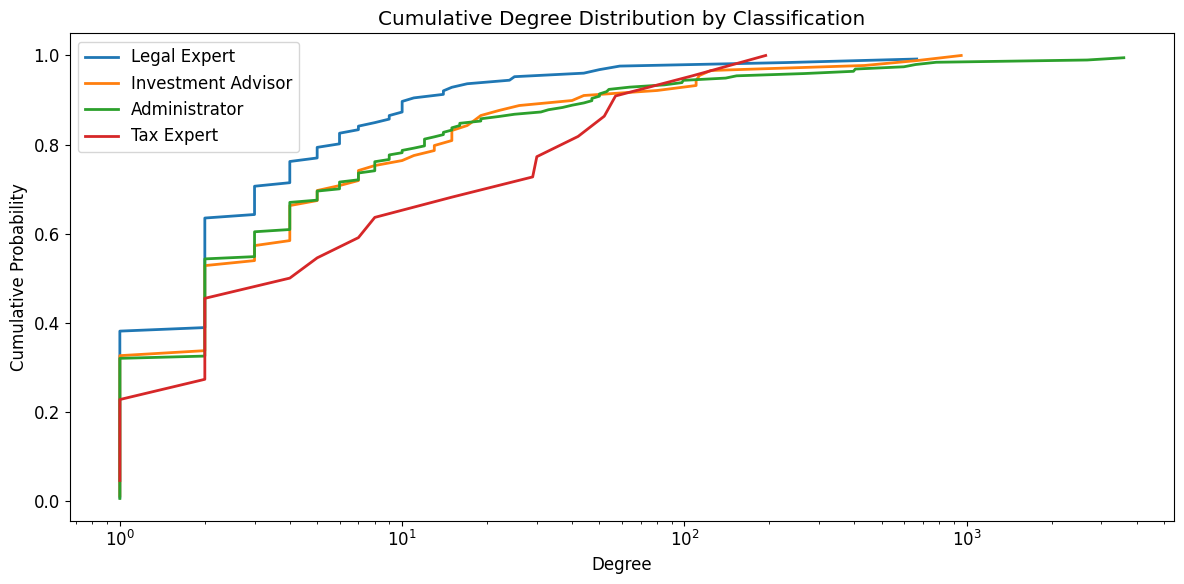

In [61]:
# Create figure for degree distributions by classification
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique classifications
classifications = merged_entities_df_enriched_random_sample_500['classification'].unique()

# Calculate and print statistics for each classification
print("\nDegree Statistics by Classification:")
for classification in classifications:
    mask = merged_entities_df_enriched_random_sample_500['classification'] == classification
    degrees = merged_entities_df_enriched_random_sample_500[mask]['degree']
    
    stats = degrees.describe()
    print(f"\n{classification}:")
    print(f"Count: {stats['count']:.0f}")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Median: {stats['50%']:.2f}")
    print(f"Std Dev: {stats['std']:.2f}")
    print(f"Min: {stats['min']:.0f}")
    print(f"Max: {stats['max']:.0f}")
    
    # Sort degrees for CDF
    sorted_degrees = np.sort(degrees)
    # Calculate CDF values
    cdf = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
    # Plot CDF
    ax.plot(sorted_degrees, cdf, label=classification, linewidth=2)



ax.set_title('Cumulative Degree Distribution by Classification')
ax.set_xlabel('Degree')
ax.set_ylabel('Cumulative Probability')
ax.set_xscale('log')
ax.legend()

plt.tight_layout()
plt.show()

### Visualising the networks

In [10]:
# dropping in-place the ones with multiple country codes - a very small proportion anyway
entities_df = entities_df[entities_df['country_codes'].str.contains(';', na=False)]


--- Processing DEU ---
Calculating layout for DEU...
Drawing network for DEU...


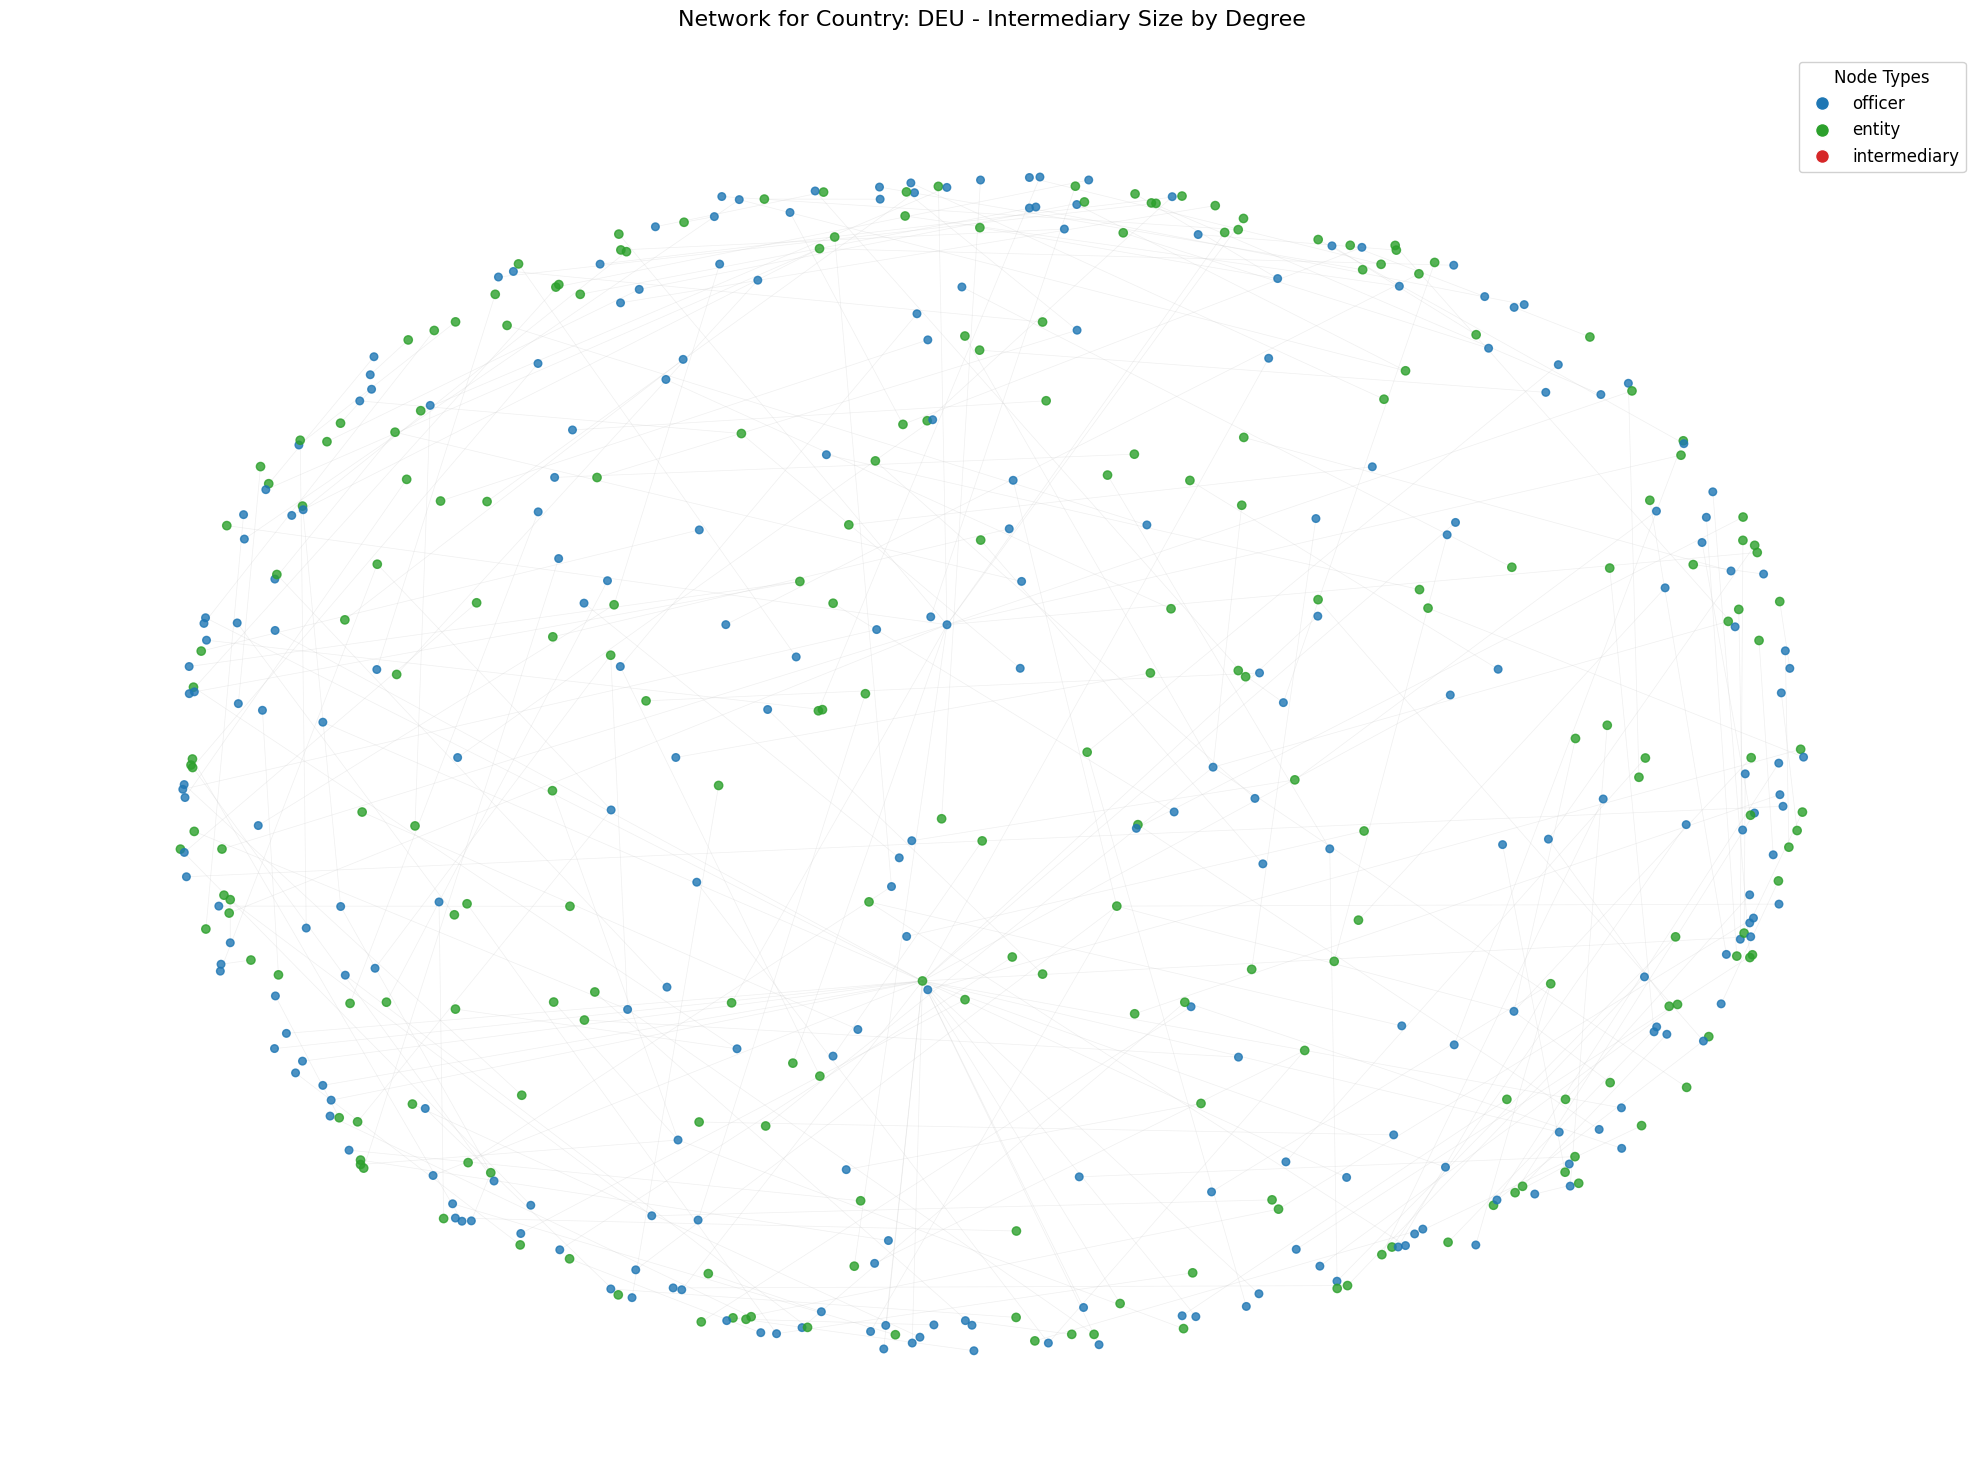


Network Statistics for DEU:
Total Nodes: 480
Total Edges: 480
Calculating betweenness centrality for DEU (may take time)...
Calculating layout for DEU...
Drawing network for DEU...


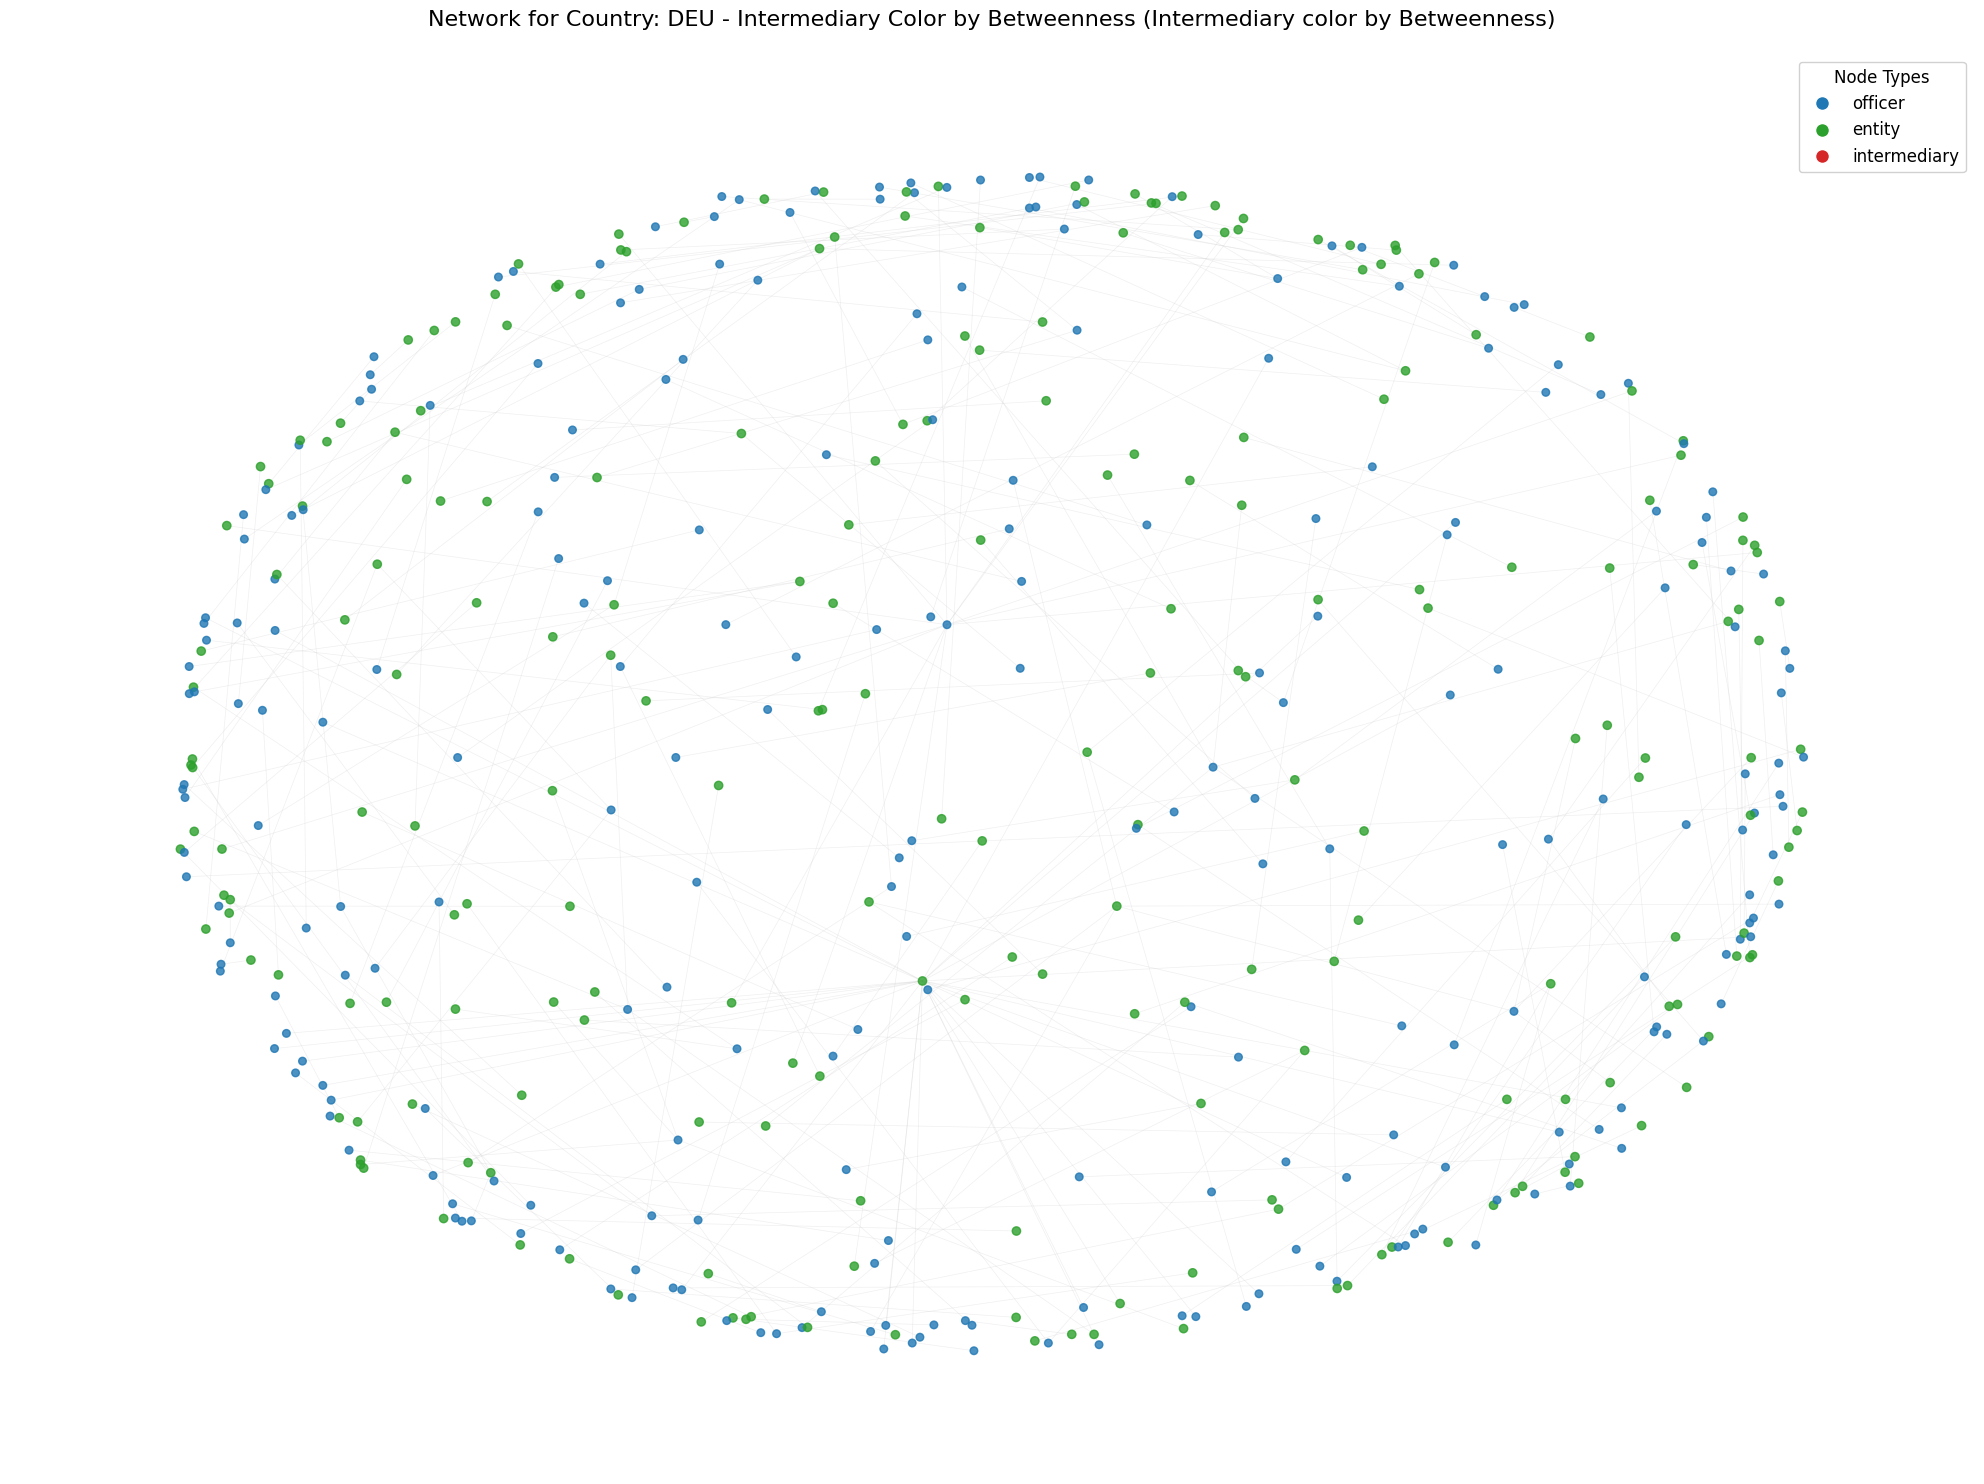


Network Statistics for DEU:
Total Nodes: 480
Total Edges: 480
Calculating betweenness centrality for DEU (may take time)...
Calculating layout for DEU...
Drawing network for DEU...


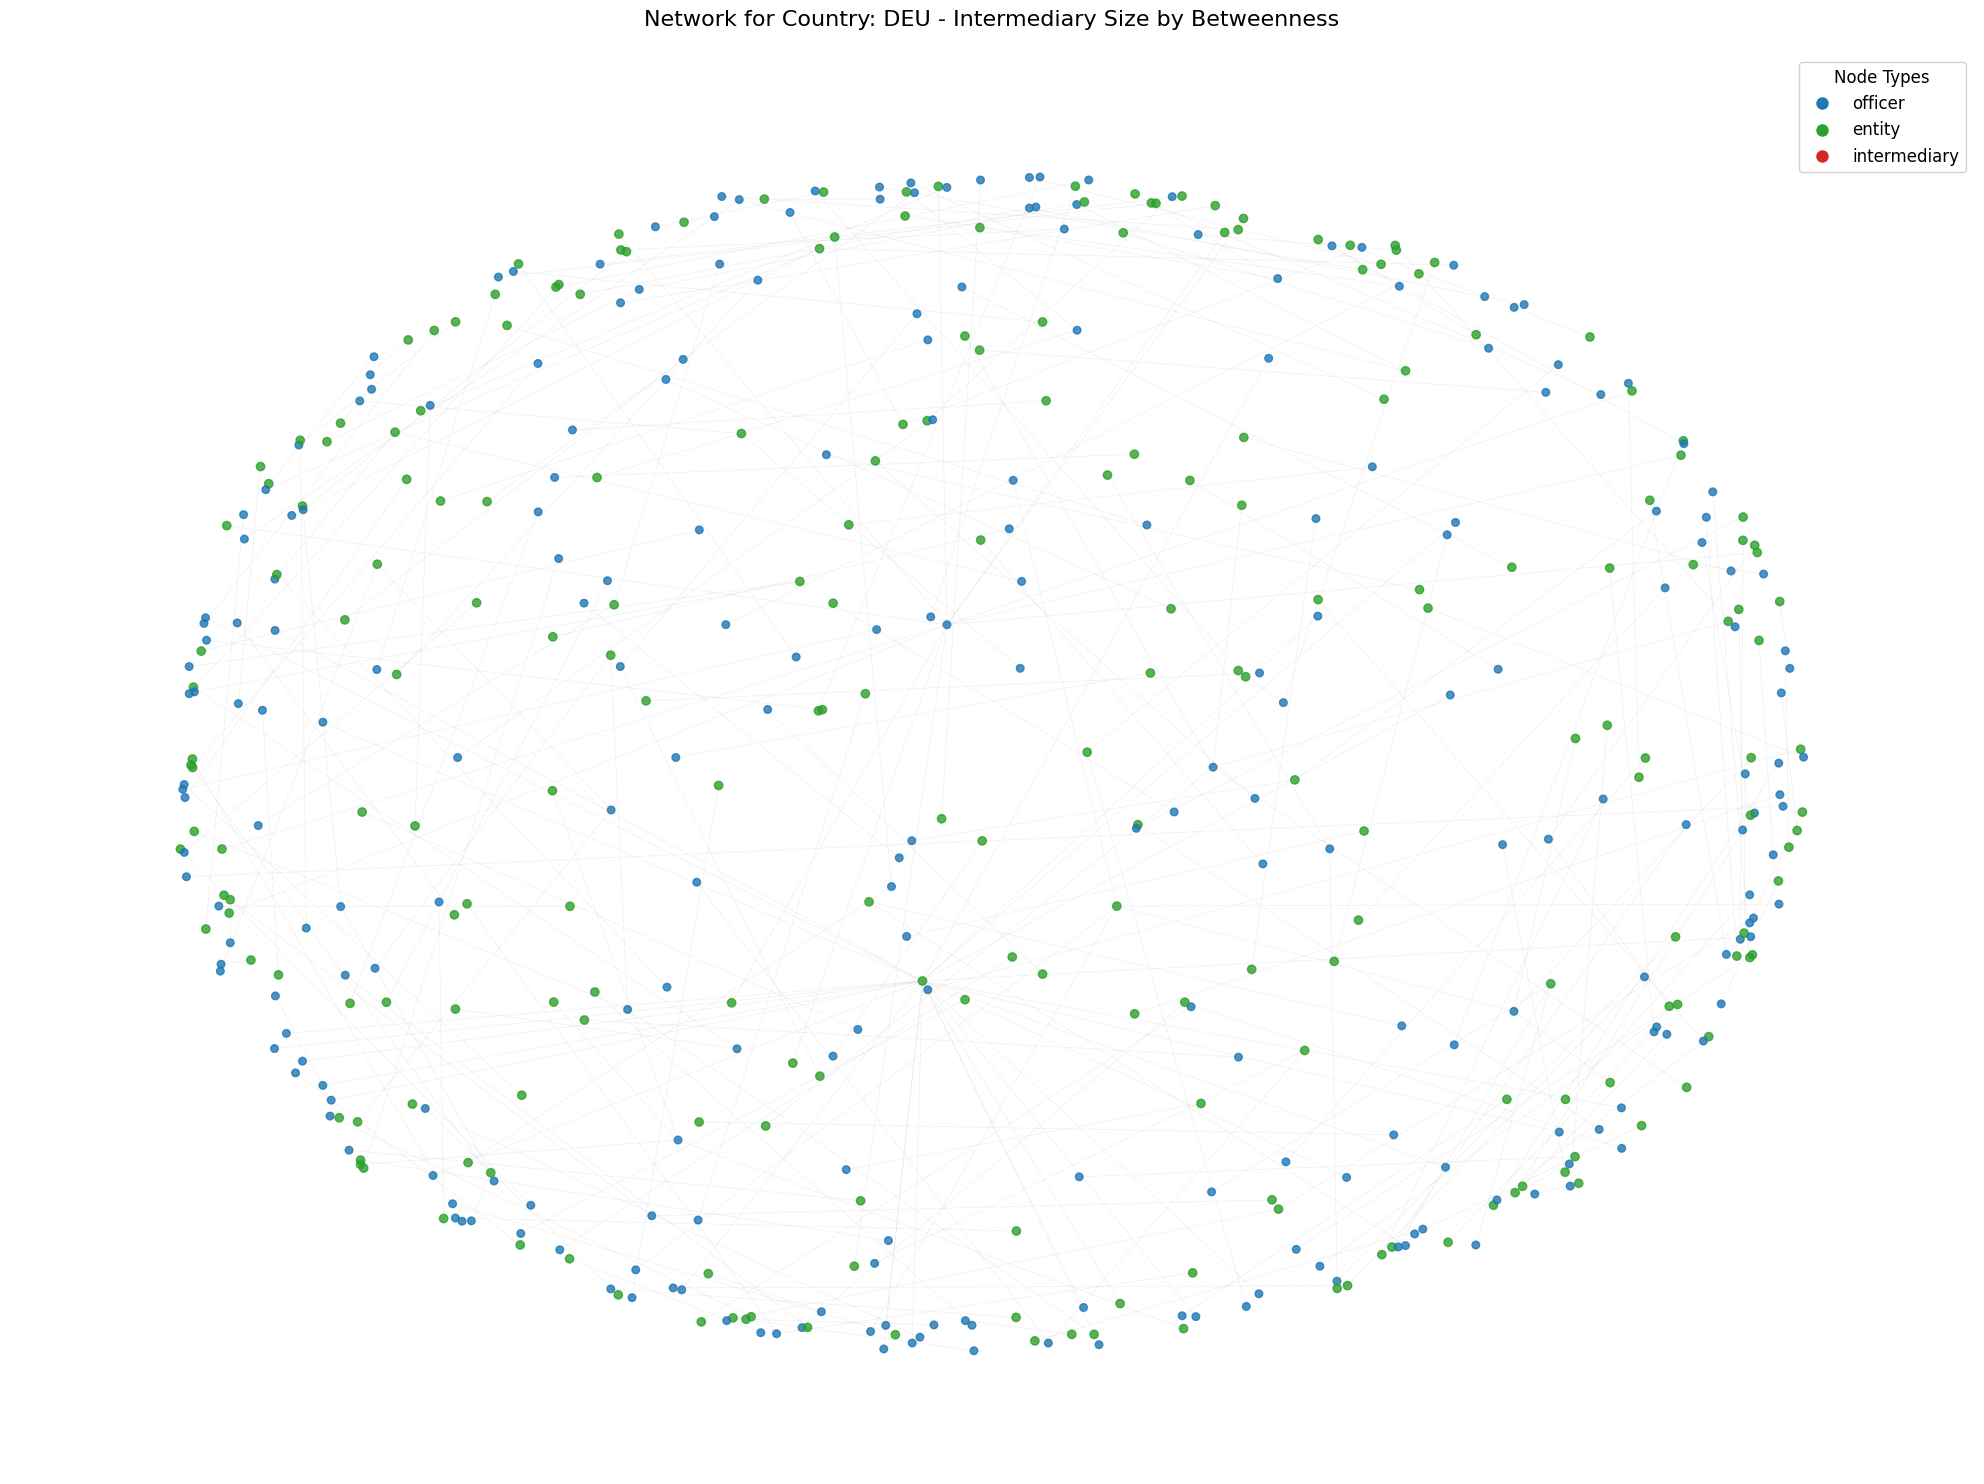


Network Statistics for DEU:
Total Nodes: 480
Total Edges: 480


In [35]:
def create_optimized_country_network(country_code, officers_df, entities_df, intermediaries_df, relationships_df, max_nodes=5000):
    """
    Create a network for a specific country from the ICIJ data with optimized performance.
    If the network exceeds max_nodes, it will be sampled to maintain performance.
    
    Parameters:
    -----------
    country_code : str
        The country code to filter by
    officers_df : pandas.DataFrame
        DataFrame containing officer data
    entities_df : pandas.DataFrame
        DataFrame containing entity data
    intermediaries_df : pandas.DataFrame
        DataFrame containing intermediary data
    relationships_df : pandas.DataFrame
        DataFrame containing relationship data
    max_nodes : int, optional
        Maximum number of nodes to include in the network (default: 5000)
        
    Returns:
    --------
    networkx.Graph
        The created network
    """
    # Pre-filter relationships to only those involving officers from the target country
    country_officers = officers_df[officers_df["country_codes"].str.contains(country_code, na=False)]
    officer_nodes = set(country_officers["node_id"])
    
    # Create a mask for relationships involving these officers
    mask = (relationships_df["node_id_start"].isin(officer_nodes) | 
            relationships_df["node_id_end"].isin(officer_nodes))
    officer_relationships = relationships_df[mask]
    
    # Extract all related nodes in one pass
    all_related_nodes = set()
    all_related_nodes.update(officer_relationships["node_id_start"].values)
    all_related_nodes.update(officer_relationships["node_id_end"].values)
    
    # Create the graph
    G = nx.Graph()
    
    # Add officer nodes
    for _, row in country_officers.iterrows():
        G.add_node(row["node_id"], node_type="officer", **row.to_dict())
    
    # Add entity nodes - batch process
    entity_mask = entities_df["node_id"].isin(all_related_nodes)
    for _, row in entities_df[entity_mask].iterrows():
        G.add_node(row["node_id"], node_type="entity", **row.to_dict())
    
    # Add intermediary nodes - batch process
    intermediary_mask = intermediaries_df["node_id"].isin(all_related_nodes)
    for _, row in intermediaries_df[intermediary_mask].iterrows():
        G.add_node(row["node_id"], node_type="intermediary", **row.to_dict())
    
    # Add edges - batch process
    for _, row in officer_relationships.iterrows():
        if (row["node_id_start"] in G.nodes) and (row["node_id_end"] in G.nodes):
            G.add_edge(row["node_id_start"], row["node_id_end"], **row.to_dict())
    
    # If network is too large, sample nodes while preserving structure
    if len(G) > max_nodes:
        # Calculate sampling ratio
        sample_ratio = max_nodes / len(G)
        
        # Sample nodes while preserving node type distribution
        sampled_nodes = set()
        for node_type in ['officer', 'entity', 'intermediary']:
            type_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == node_type]
            num_to_sample = int(len(type_nodes) * sample_ratio)
            sampled_nodes.update(random.sample(type_nodes, num_to_sample))
        
        # Create subgraph with sampled nodes and convert to new graph to avoid frozen graph
        subgraph = G.subgraph(sampled_nodes)
        G = nx.Graph(subgraph)
        
        # Remove isolated nodes
        isolated_nodes = list(nx.isolates(G))
        if isolated_nodes:
            G.remove_nodes_from(isolated_nodes)
    
    return G

def visualize_network_with_centrality(G, country_code, title_suffix="",
                                       size_by='degree', # Options: 'degree', 'betweenness', 'fixed'
                                       color_by='type',  # Options: 'type', 'betweenness'
                                       emphasize_intermediaries=True):
    """
    Visualize a network, emphasizing intermediaries using centrality metrics.

    Parameters:
    -----------
    G : networkx.Graph
        The network graph to visualize
    country_code : str
        The country code for the title
    title_suffix : str, optional
        Additional text to append to the title
    size_by : str, optional
        Metric to determine node size ('degree', 'betweenness', 'fixed'). Default: 'degree'.
    color_by : str, optional
        Metric or attribute to determine node color ('type', 'betweenness'). Default: 'type'.
    emphasize_intermediaries : bool, optional
        If True, centrality scaling is primarily applied to intermediaries. Default: True.
    """
    if G.number_of_nodes() == 0:
        print(f"Network for {country_code} is empty. Skipping visualization.")
        return

    plt.figure(figsize=(20, 15))
    plt.gca().set_facecolor('white')

    # --- Centrality Calculations ---
    degrees = dict(G.degree())
    # Betweenness can be computationally expensive for large graphs
    if size_by == 'betweenness' or color_by == 'betweenness':
        print(f"Calculating betweenness centrality for {country_code} (may take time)...")
        try:
            # Use a sample for large graphs to speed up calculation if needed
            if G.number_of_nodes() > 2000:
                 # k = number of nodes to sample for approximation
                 betweenness = nx.betweenness_centrality(G, k=min(1000, G.number_of_nodes()//2), normalized=True, seed=42)
                 print(" (Approximated)")
            else:
                 betweenness = nx.betweenness_centrality(G, normalized=True)
        except Exception as e:
            print(f"Could not calculate betweenness centrality: {e}. Using fixed size/type color.")
            betweenness = {node: 0 for node in G.nodes()} # Default to 0 if calculation fails
            size_by = 'fixed' if size_by == 'betweenness' else size_by
            color_by = 'type' if color_by == 'betweenness' else color_by
    else:
        betweenness = {} # Not needed

    # --- Node Visual Properties ---
    node_colors_map = {
        'officer': '#1f77b4',      # Blue
        'entity': '#2ca02c',       # Green
        'intermediary': '#d62728'   # Red
    }
    base_size = 50 if len(G) < 100 else 30
    intermediary_size_multiplier = 10 # How much to scale intermediary size by degree/betweenness
    intermediary_color_map = cm.YlOrRd # Colormap for intermediary betweenness

    node_sizes = []
    node_colors = []

    # Normalize betweenness for coloring if needed
    if color_by == 'betweenness':
        interm_betweenness = [betweenness.get(n, 0) for n, d in G.nodes(data=True) if d.get('node_type') == 'intermediary']
        if interm_betweenness:
             # Handle cases where all betweenness values might be the same (or zero)
             min_b = min(interm_betweenness)
             max_b = max(interm_betweenness)
             if min_b == max_b:
                 norm = mcolors.Normalize(vmin=min_b - 1e-6, vmax=max_b + 1e-6) # Avoid division by zero
             else:
                 norm = mcolors.Normalize(vmin=min_b, vmax=max_b)
        else:
             # Handle case with no intermediaries
             norm = mcolors.Normalize(vmin=0, vmax=1)

    for node, data in G.nodes(data=True):
        node_type = data.get('node_type', 'unknown') # Use .get for safety

        # --- Determine Node Size ---
        current_size = base_size
        if node_type == 'intermediary' and emphasize_intermediaries:
            if size_by == 'degree':
                current_size = base_size + degrees.get(node, 0) * intermediary_size_multiplier
            elif size_by == 'betweenness':
                 # Scale betweenness (0-1) to a reasonable size range
                 current_size = base_size + betweenness.get(node, 0) * intermediary_size_multiplier * 100
        elif node_type == 'entity':
             current_size = base_size * 1.2 # Make entities slightly larger by default
        # (Non-intermediaries keep base_size if emphasize_intermediaries is True and size_by is centrality)
        node_sizes.append(current_size)

        # --- Determine Node Color ---
        current_color = node_colors_map.get(node_type, '#808080') # Default grey
        if color_by == 'betweenness' and node_type == 'intermediary' and emphasize_intermediaries:
            if betweenness: # Check if betweenness was calculated
                current_color = intermediary_color_map(norm(betweenness.get(node, 0)))
        elif color_by == 'type':
             current_color = node_colors_map.get(node_type, '#808080')
        node_colors.append(current_color)


    # --- Layout ---
    print(f"Calculating layout for {country_code}...")
    if len(G) > 1000:
        pos = nx.spring_layout(G, k=1.5/((len(G))**0.5), iterations=50, seed=42) # Adjust k based on size
    else:
        pos = nx.spring_layout(G, k=0.8, iterations=100, seed=42) # More iterations for smaller graphs

    # --- Drawing ---
    print(f"Drawing network for {country_code}...")
    # Draw edges first
    nx.draw_networkx_edges(G, pos,
                          edge_color='#cccccc',
                          alpha=0.3,
                          width=0.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.8)

    # --- Legend ---
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=color, label=node_type, markersize=10)
                      for node_type, color in node_colors_map.items()]

    # Add colorbar legend if coloring by betweenness
    if color_by == 'betweenness' and emphasize_intermediaries:
        sm = plt.cm.ScalarMappable(cmap=intermediary_color_map, norm=norm)
        sm.set_array([])
        # cbar = plt.colorbar(sm, shrink=0.5, aspect=10, pad=0.02)
        # cbar.set_label('Intermediary Betweenness Centrality', rotation=270, labelpad=15)
        # Add a note about approximation if used
        title_suffix += " (Intermediary color by Betweenness)"
        if G.number_of_nodes() > 2000 and 'betweenness' in locals() and betweenness:
             title_suffix += " [Approx.]"


    plt.legend(handles=legend_elements,
              loc='upper right',
              frameon=True,
              framealpha=0.9,
              fontsize=12,
              title="Node Types")

    plt.title(f'Network for Country: {country_code}{title_suffix}',
              fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Print Stats (Optional - Keep your existing stats printing) ---
    print(f"\nNetwork Statistics for {country_code}:")
    print(f"Total Nodes: {G.number_of_nodes():,}")
    print(f"Total Edges: {G.number_of_nodes():,}")
    # ... (rest of your stats printing code) ...

# --- Example Usage ---
# Assuming you have your DataFrames loaded: officers_df, entities_df, etc.

# countries = ['KEN', 'GBR', 'DEU', 'FRA', 'ITA', 'ESP', 'NLD', 'CHE', 'LUX']
countries = ['DEU'] # Example: Just run for one country initially

for country_code in countries:
    print(f"\n--- Processing {country_code} ---")
    # Create network
    country_network = create_optimized_country_network(country_code, officers_df, entities_df, intermediaries_df, relationships_df, max_nodes=2500) # Smaller max_nodes for testing

    # Visualize with intermediaries sized by degree
    visualize_network_with_centrality(country_network, country_code,
                                       title_suffix=" - Intermediary Size by Degree",
                                       size_by='degree',
                                       color_by='type',
                                       emphasize_intermediaries=True)

    # Visualize with intermediaries colored by betweenness (can be slow)
    visualize_network_with_centrality(country_network, country_code,
                                       title_suffix=" - Intermediary Color by Betweenness",
                                       size_by='fixed', # Keep size fixed or use degree
                                       color_by='betweenness',
                                       emphasize_intermediaries=True)

    # Visualize with intermediaries sized by betweenness (can be slow)
    visualize_network_with_centrality(country_network, country_code,
                                       title_suffix=" - Intermediary Size by Betweenness",
                                       size_by='betweenness',
                                       color_by='type', # Keep color by type
                                       emphasize_intermediaries=True)


In [4]:
import pandas as pd

df = pd.read_csv("enrichment_data/enriched_random_sample_500.csv")
df.shape

(739, 10)

In [5]:
df.head()

,name,classification,confidence,role_muddled,role_muddled_reasoning,justification,is_individual,job_title,search_log,search_iterations
0,OPULENT OPAL HOLDINGS LIMITED,Administrator,Low,True,The role is muddled as the search results are ...,The search results provide limited information...,False,Unknown,"[{'iteration': 0, 'query': 'OPULENT OPAL HOLDI...",3.0
1,Cheo Yeoh & Associates,Legal Expert,High,False,NaN,Cheo Yeoh & Associates LLC provides legal serv...,False,Lawyer,"[{'iteration': 0, 'query': 'Cheo Yeoh & Associ...",3.0
2,"JORGE CARLOS RACHETTI BUTLER,",Investment Advisor,High,False,NaN,Jorge Carlos Rachetti Butler is the CEO of Lai...,True,Chief Executive Officer,"[{'iteration': 0, 'query': 'JORGE CARLOS RACHE...",3.0
3,John Alan Tull,Legal Expert,High,False,NaN,John Alan Tull has a long career in legal serv...,True,Management Consultant,"[{'iteration': 0, 'query': 'John Alan Tull', '...",3.0
4,FALCON MUSKUS - ABOGADOS,Legal Expert,High,False,The role is clearly defined as a law firm.,Falcon Muskus Abogados is a law firm that prov...,False,Law Firm,"[{'iteration': 0, 'query': 'FALCON MUSKUS - AB...",3.0


In [49]:
import itertools # Needed for combinations


def create_intermediary_connection_network(G_full):
    """
    Creates a network where nodes are intermediaries, and an edge exists
    if two intermediaries are connected to the same officer or entity in the
    original full graph (G_full).

    Parameters:
    -----------
    G_full : networkx.Graph
        The original network containing officers, entities, and intermediaries.
        Nodes must have a 'node_type' attribute.

    Returns:
    --------
    networkx.Graph
        A new graph where nodes are intermediaries and edges represent
        shared connections via officers or entities. Edges have a 'weight'
        attribute indicating the number of shared connections and a
        'shared_nodes' attribute listing the IDs of the shared officers/entities.
    """
    G_inter = nx.Graph()
    intermediaries = {n for n, d in G_full.nodes(data=True) if d.get('node_type') == 'intermediary'}

    if not intermediaries:
        print("No intermediary nodes found in the original graph.")
        return G_inter

    # Add intermediary nodes to the new graph, copying attributes
    for inter_node_id in intermediaries:
        G_inter.add_node(inter_node_id, **G_full.nodes[inter_node_id])

    # Use a dictionary to store edge weights and shared nodes temporarily
    # Key: tuple(sorted(intermediary1, intermediary2)), Value: {'weight': count, 'shared_nodes': set()}
    edge_data = defaultdict(lambda: {'weight': 0, 'shared_nodes': set()})

    # Iterate through potential bridging nodes (officers and entities) in the original graph
    for node_id, data in G_full.nodes(data=True):
        node_type = data.get('node_type')
        if node_type == 'officer' or node_type == 'entity':
            # Find neighbors of this bridging node
            neighbors = list(G_full.neighbors(node_id))
            # Filter neighbors to find connected intermediaries
            connected_intermediaries = {n for n in neighbors if n in intermediaries}

            # If this node connects 2 or more intermediaries, add/update edges between them
            if len(connected_intermediaries) >= 2:
                # Iterate through all unique pairs of connected intermediaries
                for i1, i2 in itertools.combinations(connected_intermediaries, 2):
                    # Ensure consistent edge key ordering
                    edge_key = tuple(sorted((i1, i2)))
                    edge_data[edge_key]['weight'] += 1
                    edge_data[edge_key]['shared_nodes'].add(node_id)

    # Add the collected edges to the graph
    for (u, v), attributes in edge_data.items():
        G_inter.add_edge(u, v, **attributes)

    print(f"Created intermediary connection network with {G_inter.number_of_nodes()} nodes and {G_inter.number_of_edges()} edges.")
    return G_inter

# --- Modified Visualization Function (Example: Adding Edge Width) ---

def visualize_intermediary_network(G_inter, country_code, title_suffix="",
                                   size_by='degree', # Options: 'degree', 'betweenness', 'fixed'
                                   color_by='degree', # Options: 'degree', 'betweenness', 'fixed'
                                   edge_width_by='weight'): # Options: 'weight', 'fixed'
    """
    Visualize the intermediary connection network.

    Parameters:
    -----------
    G_inter : networkx.Graph
        The intermediary connection network.
    country_code : str
        The country code for the title.
    title_suffix : str, optional
        Additional text to append to the title.
    size_by : str, optional
        Metric for node size in the intermediary network. Default: 'degree'.
    color_by : str, optional
        Metric for node color in the intermediary network. Default: 'degree'.
    edge_width_by : str, optional
        Attribute for edge width. Default: 'weight'.
    """
    if G_inter.number_of_nodes() == 0:
        print(f"Intermediary network for {country_code} is empty. Skipping visualization.")
        return

    plt.figure(figsize=(20, 15))
    plt.gca().set_facecolor('white')

    # --- Centrality Calculations (within G_inter) ---
    degrees = dict(G_inter.degree())
    betweenness = {}
    if size_by == 'betweenness' or color_by == 'betweenness':
        print(f"Calculating betweenness centrality for {country_code} intermediary network...")
        # Use approximation if large, though intermediary networks are often smaller
        if G_inter.number_of_nodes() > 1000:
             betweenness = nx.betweenness_centrality(G_inter, k=min(500, G_inter.number_of_nodes()//2), normalized=True, seed=42)
             print(" (Approximated)")
        else:
             betweenness = nx.betweenness_centrality(G_inter, normalized=True)

    # --- Node Visual Properties ---
    node_sizes = []
    node_colors = []
    base_size = 100
    size_multiplier = 20
    color_map = cm.YlOrRd # Use a heatmap for centrality

    # Normalize centrality for coloring
    color_values = []
    if color_by == 'degree':
        color_values = [degrees.get(n, 0) for n in G_inter.nodes()]
    elif color_by == 'betweenness':
        color_values = [betweenness.get(n, 0) for n in G_inter.nodes()]

    if color_values:
        min_c = min(color_values)
        max_c = max(color_values)
        if min_c == max_c:
             norm = mcolors.Normalize(vmin=min_c - 1e-6, vmax=max_c + 1e-6)
        else:
             norm = mcolors.Normalize(vmin=min_c, vmax=max_c)
    else: # Fixed color
        norm = mcolors.Normalize(vmin=0, vmax=1)


    for node in G_inter.nodes():
        # --- Determine Node Size ---
        current_size = base_size
        if size_by == 'degree':
            current_size = base_size + degrees.get(node, 0) * size_multiplier
        elif size_by == 'betweenness':
            current_size = base_size + betweenness.get(node, 0) * size_multiplier * 100
        node_sizes.append(current_size)

        # --- Determine Node Color ---
        current_color = '#d62728' # Default red for intermediaries
        if color_by == 'degree':
            current_color = color_map(norm(degrees.get(node, 0)))
        elif color_by == 'betweenness':
            current_color = color_map(norm(betweenness.get(node, 0)))
        node_colors.append(current_color)

    # --- Edge Width ---
    edge_widths = []
    if edge_width_by == 'weight':
        weights = [G_inter.edges[u, v].get('weight', 1) for u, v in G_inter.edges()]
        # Normalize weights for better visualization (e.g., log scale or cap max width)
        max_weight = max(weights) if weights else 1
        edge_widths = [0.1 + 2.5 * (w / max_weight) for w in weights] # Example scaling
    else:
        edge_widths = [0.5] * G_inter.number_of_edges() # Fixed width

    # --- Layout ---
    print(f"Calculating layout for {country_code} intermediary network...")
    # Use a layout suitable for potentially smaller/denser graphs
    pos = nx.spring_layout(G_inter, k=1.0/((G_inter.number_of_nodes())**0.5) if G_inter.number_of_nodes() > 0 else 1, iterations=100, seed=42)

    # --- Drawing ---
    print(f"Drawing network for {country_code} intermediary network...")
    nx.draw_networkx_edges(G_inter, pos,
                          edge_color='#cccccc',
                          alpha=0.4,
                          width=edge_widths)

    nx.draw_networkx_nodes(G_inter, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.9)

    # Add labels (optional, can be cluttered)
    # labels = {n: G_inter.nodes[n].get('name', n)[:10] for n in G_inter.nodes()} # Short names
    # nx.draw_networkx_labels(G_inter, pos, labels=labels, font_size=8)

    # --- Legend ---
    if color_values:
        sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
        sm.set_array([])
        # cbar = plt.colorbar(sm, shrink=0.5, aspect=10, pad=0.02)
        # cbar.set_label(f'Intermediary {color_by.capitalize()} Centrality', rotation=270, labelpad=15)
        if 'betweenness' in color_by and G_inter.number_of_nodes() > 1000:
             title_suffix += " [Betweenness Approx.]"

    plt.title(f'Intermediary Connection Network for Country: {country_code}{title_suffix}',
              fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print some stats specific to this network
    print(f"\nIntermediary Network Statistics for {country_code}:")
    print(f"Total Intermediary Nodes: {G_inter.number_of_nodes():,}")
    print(f"Total Connections (Edges): {G_inter.number_of_edges():,}")
    if G_inter.number_of_edges() > 0:
        avg_weight = sum(d['weight'] for u, v, d in G_inter.edges(data=True)) / G_inter.number_of_edges()
        print(f"Average Connection Weight (Shared Nodes): {avg_weight:.2f}")
        max_weight_edge = max(G_inter.edges(data=True), key=lambda x: x[2]['weight'])
        print(f"Maximum Connection Weight: {max_weight_edge[2]['weight']}")


# --- Example Usage ---

# Assuming you have your DataFrames loaded: officers_df, entities_df, etc.
# And the create_optimized_country_network function defined

# countries = ['KEN', 'GBR', 'DEU', 'FRA', 'ITA', 'ESP', 'NLD', 'CHE', 'LUX']
countries = ['BVI'] # Example: Just run for Luxembourg

for country_code in countries:
    print(f"\n--- Processing {country_code} ---")
    # 1. Create the full network first
    full_network = create_optimized_country_network(country_code, officers_df, entities_df, intermediaries_df, relationships_df, max_nodes=5000)

    if full_network.number_of_nodes() > 0:
        # 2. Create the intermediary connection network from the full network
        intermediary_network = create_intermediary_connection_network(full_network)

        # 3. Visualize the intermediary network
        if intermediary_network.number_of_nodes() > 0:
            visualize_intermediary_network(intermediary_network, country_code,
                                           title_suffix=" (Nodes colored by Degree)",
                                           size_by='degree',
                                           color_by='degree',
                                           edge_width_by='weight')

            # Example: Visualize colored by betweenness
            visualize_intermediary_network(intermediary_network, country_code,
                                           title_suffix=" (Nodes colored by Betweenness)",
                                           size_by='degree', # Keep size by degree
                                           color_by='betweenness',
                                           edge_width_by='weight')
        else:
            print(f"No intermediary connections found for {country_code}.")
    else:
        print(f"Full network for {country_code} was empty.")




--- Processing BVI ---
No intermediary nodes found in the original graph.
No intermediary connections found for BVI.
